In [1]:
# GNN and Tabular Transformer (Address-level)
# Single-file notebook-style script using cell separators (for Jupyter/VSCode: Run cells)
# This version is tailored for the provided file: /mnt/data/ethereum_raw.csv
# It assumes the file is already address-level with columns: 'Address' (ID) and 'FLAG' (label).
# The notebook will: load data, preprocess, build a KNN similarity graph for GNN, train a node-classifier GNN and a Tabular Transformer, evaluate and save artifacts.


In [2]:
# 1) Setup & imports

# Standard library imports
import os                     # filesystem operations (paths, mkdir)
import random                 # pseudo-random utilities (seed, random)
import pickle                 # serialization for saving/loading Python objects

# Data science / numeric libraries
import numpy as np            # numerical arrays and operations
import pandas as pd           # tabular data handling (DataFrame)

# PyTorch (deep learning)
import torch                  # core PyTorch (tensors, device handling, random seeds)
import torch.nn as nn         # neural network building blocks (modules, layers)
import torch.nn.functional as F  # functional forms of common layers / losses
import hashlib  
import json   
# Scikit-learn utilities for preprocessing, splitting and evaluation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,                  # AUC-ROC metric
    precision_recall_curve,        # precision-recall curve helper
    auc,                           # area under curve helper (used for PR AUC)
    precision_recall_fscore_support,# detailed precision/recall/fscore per class
    accuracy_score                 # simple accuracy metric
)
from sklearn.neighbors import NearestNeighbors  # for computing nearest neighbors (graph construction / overlap checks)

# Optional: PyTorch Geometric (graph neural network utilities)
# Wrapped in try/except because not all environments have torch_geometric installed.
try:
    import torch_geometric
    from torch_geometric.data import Data   # container for graph data (node features, edge index, labels)
    from torch_geometric.nn import SAGEConv # GraphSAGE convolution layer (used for GNN)
except Exception as e:
    # If import fails, print a clear message but allow the notebook to continue (we might only run baselines).
    print("torch_geometric not installed or import failed:", e)

# Optional: LightGBM for baseline gradient-boosted trees
# Wrapped in try/except so notebook still runs even if lightgbm is missing.
try:
    import lightgbm as lgb
except Exception:
    lgb = None  # mark as unavailable — downstream code should check this before using LightGBM

# Reproducibility: fix random seeds for Python, NumPy and PyTorch
SEED = 42
random.seed(SEED)        # seed Python's random
np.random.seed(SEED)     # seed NumPy's RNG
# If CUDA is available, also set CUDA seeds and deterministic flags to reduce nondeterminism
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # Force deterministic convolution algorithms (may slow training but improves reproducibility)
    torch.backends.cudnn.deterministic = True
    # Disable benchmark to prevent nondeterministic algorithm selection
    torch.backends.cudnn.benchmark = False

# Paths and artifacts
DATA_PATH = 'E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv'  # raw CSV dataset path
ARTIFACTS_DIR = './artifacts'  # directory to store outputs (models, processed data, logs)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)  # create artifacts directory if it doesn't exist


In [3]:
# 2) Load CSV & quick EDA (Exploratory Data Analysis)

# Print which file is being loaded for clarity
print('Loading', DATA_PATH)

# Load the Ethereum dataset from the specified CSV file path into a pandas DataFrame
df = pd.read_csv(DATA_PATH)

# Display the number of rows (samples) and columns (features) to understand dataset size
print('Rows, cols:', df.shape)

# Print the list of all column names to get an overview of available features
print(df.columns.tolist())

# Show the first 3 rows of the dataset to visually inspect structure, datatypes, and example values
print(df.head(3))


Loading E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv
Rows, cols: (9841, 51)
['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between 

In [4]:
# 3) Remove leaking or redundant index-like columns

# Some CSV exports (especially from pandas) include an extra "Unnamed: 0" or "Index" column 
# that simply duplicates the row index — this can leak information during model training.
# The following code checks for such columns and drops them if they exist.

if 'Unnamed: 0' or 'Index' in df.columns:
    # Drop both columns if present; errors='ignore' ensures no error is raised if not found
    df = df.drop(columns=['Unnamed: 0', 'Index'], errors='ignore')

# Display the first 5 rows again to confirm that unwanted columns are removed
df.head(5)


,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [5]:
# # 4) Train/validation/test split + preprocessing (fit transformers on TRAIN only)

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# import pickle, numpy as np, os

# # Assumptions: df is already loaded, contains columns 'Address' and 'FLAG'
# # If your notebook had explicit lists for numeric/categorical columns, reuse them.
# # Otherwise auto-detect:
# # Build feature list by excluding identifier/target-like columns
# feature_cols = [c for c in df.columns if c not in ('Address', 'FLAG', 'flag', 'Label', 'label')]
# addresses = df['Address'].values               # keep original addresses (for later mapping / graph construction)
# y = df['FLAG'].values                           # target labels array

# # crude split of categorical vs numeric (you can override lists if you had custom lists)
# # Treat columns as categorical if dtype==object OR they have low cardinality (<50 unique values)
# categorical_cols = [c for c in feature_cols if df[c].dtype == 'object' or df[c].nunique() < 50]
# numeric_cols = [c for c in feature_cols if c not in categorical_cols]  # remaining considered numeric
# print(numeric_cols)
# print(categorical_cols)
# # INDEX-BASED SPLIT (stratified to preserve class balance)
# idx = np.arange(len(df))  # array of row indices
# # Hold out 20% for final test set, stratifying by the label y to keep class proportions
# train_idx, test_idx = train_test_split(idx, test_size=0.20, random_state=SEED, stratify=y)
# # From the remaining training indices, split a validation set (15% of the original train indices)
# train_idx, val_idx  = train_test_split(train_idx, test_size=0.15, random_state=SEED, stratify=y[train_idx])
# print(f"Split sizes: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

# # Prepare raw column-wise DataFrames for convenience (we will transform these)
# X_raw_num = df[numeric_cols].copy()   # numeric features (may contain NaNs)
# X_raw_cat = df[categorical_cols].copy()# categorical features (strings / low-cardinality values)

# # --- Fit transformers ON TRAIN ONLY --- (important: avoid leakage from validation/test)
# # 1) LabelEncoders for categorical columns
# cat_encoders = {}  # will store fitted label encoders + mapping + unknown index per column
# # Preallocate an integer array to hold encoded categorical values for all rows
# X_cat = np.empty((len(df), len(categorical_cols)), dtype=np.int32)
# for i, col in enumerate(categorical_cols):
#     le = LabelEncoder()
#     # Replace missing values with a sentinel token and convert to string before fitting
#     train_vals = X_raw_cat.iloc[train_idx][col].fillna("<<NA>>").astype(str)
#     le.fit(train_vals)  # fit only on training values to avoid leakage
#     # Create a mapping from observed category value -> integer index
#     mapping = {v: idx_ for idx_, v in enumerate(le.classes_)}
#     unk_index = len(mapping)  # reserve a new index for unseen categories in val/test
#     # Apply mapping to all rows safely: map known values, unseen values -> unk_index
#     X_cat[:, i] = X_raw_cat[col].fillna("<<NA>>").astype(str).map(lambda x: mapping.get(x, unk_index)).values
#     # Save encoder info so we can inverse-transform or reuse later
#     cat_encoders[col] = {"label_encoder": le, "mapping": mapping, "unk_index": unk_index}

# # 2) StandardScaler for numeric columns (fit on train numeric only)
# scaler = StandardScaler()
# # Fill NaNs with 0 for fitting (simple imputation). Important: fit on train rows only.
# scaler.fit(X_raw_num.iloc[train_idx].fillna(0).values)

# # transform numeric features for all rows using the fitted scaler (same imputation strategy)
# X_num_scaled = scaler.transform(X_raw_num.fillna(0).values)

# # --- Build final X arrays (concatenate numeric + encoded categorical) ---
# # Cast categorical encodings to float and hstack with scaled numeric features for model compatibility
# X_all = np.hstack([X_num_scaled, X_cat.astype(float)])   # final feature matrix (rows x features)

# # split into train/val/test arrays using previously computed indices
# X_train = X_all[train_idx]
# X_val   = X_all[val_idx]
# X_test  = X_all[test_idx]

# y_train = y[train_idx]
# y_val   = y[val_idx]
# y_test  = y[test_idx]

# # Also split addresses so we can map back predictions to original entities later
# addresses_train = addresses[train_idx]
# addresses_val   = addresses[val_idx]
# addresses_test  = addresses[test_idx]

# # drop = ['suspect_col1','suspect_col2']
# # X_train = X_train.drop(columns=drop).values  # adapt to your code if you need to remove columns after building X

# print("Feature count:", X_all.shape[1])

# # Save artifacts (scalers/encoders + splits) so downstream cells use train-fitted objects
# os.makedirs(ARTIFACTS_DIR, exist_ok=True)
# with open(os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl"), "wb") as f:
#     # Persist column lists, encoders, and the scaler so later cells (or other runs) can load and reproduce transforms
#     pickle.dump({"categorical_cols": categorical_cols,
#                  "numeric_cols": numeric_cols,
#                  "cat_encoders": cat_encoders,
#                  "scaler": scaler,
#                  "feature_cols": feature_cols}, f)

# # Save numpy splits used by later cells for quick loading (avoids re-running preprocessing)
# np.save(os.path.join(ARTIFACTS_DIR, "X_train.npy"), X_train)
# np.save(os.path.join(ARTIFACTS_DIR, "X_val.npy"), X_val)
# np.save(os.path.join(ARTIFACTS_DIR, "X_test.npy"), X_test)
# np.save(os.path.join(ARTIFACTS_DIR, "y_train.npy"), y_train)
# np.save(os.path.join(ARTIFACTS_DIR, "y_val.npy"), y_val)
# np.save(os.path.join(ARTIFACTS_DIR, "y_test.npy"), y_test)
# np.save(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), addresses_train)
# np.save(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), addresses_val)
# np.save(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), addresses_test)

# print("Saved train-only preproc artifacts to", ARTIFACTS_DIR)
# # ----- END REPLACEMENT BLOCK -----


In [6]:
# Replacement block: dedupe addresses, 80/20 group-aware split, train-only preprocessing, feature lists + checks

from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np, pandas as pd, os, pickle, scipy.stats as stats

# --- Config defaults (override if already set) ---
SEED = globals().get("SEED", 42)
ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# --- 0) Sanity checks ---
assert 'Address' in df.columns, "DataFrame must contain an 'Address' column"
assert 'FLAG' in df.columns, "DataFrame must contain a 'FLAG' column"

# --- 1) Detect duplicate addresses and resolve them ---
addr_counts = df['Address'].value_counts()
n_duplicates = (addr_counts > 1).sum()
print(f"Unique addresses: {df['Address'].nunique()}, Addresses with >1 row: {n_duplicates}")

if n_duplicates == 0:
    print("No duplicate addresses found — skipping deduplication.")
    df_dedup = df.copy()
else:
    print("Performing group-wise deduplication (numeric: mean, categorical: mode).")
    # choose feature columns (exclude identifiers/targets)
    exclude_cols = {'Address', 'FLAG', 'flag', 'Label', 'label'}
    feature_cols = [c for c in df.columns if c not in exclude_cols]

    # identify numeric / categorical heuristically
    categorical_cols = [c for c in feature_cols if df[c].dtype == 'object' or df[c].nunique() < 50]
    numeric_cols = [c for c in feature_cols if c not in categorical_cols]

    # group by Address and perform aggregation
    groups = df.groupby('Address')

    agg_frames = []
    dropped_addresses = []
    for addr, g in groups:
        flags = g['FLAG'].astype(int).values
        # if all flags equal -> keep that label
        if np.all(flags == flags[0]):
            resolved_flag = int(flags[0])
        else:
            # majority vote
            vals, counts = np.unique(flags, return_counts=True)
            max_count = counts.max()
            winners = vals[counts == max_count]
            if len(winners) == 1:
                resolved_flag = int(winners[0])
            else:
                # tie -> skip this address to avoid noisy label
                dropped_addresses.append(addr)
                continue

        # aggregate numeric features (mean)
        if numeric_cols:
            num_row = g[numeric_cols].astype(float).mean(axis=0)
        else:
            num_row = pd.Series(dtype=float)

        # aggregate categorical features (mode) with fallback to first non-null
        cat_row_vals = {}
        for c in categorical_cols:
            mode_val = None
            try:
                mode_series = g[c].dropna().astype(str)
                if len(mode_series) == 0:
                    mode_val = np.nan
                else:
                    mode_val = mode_series.mode().iat[0]
            except Exception:
                mode_val = g[c].astype(str).iloc[0]  # fallback
            cat_row_vals[c] = mode_val

        # build aggregated row
        row = {"Address": addr, "FLAG": resolved_flag}
        row.update(num_row.to_dict())
        row.update(cat_row_vals)
        agg_frames.append(row)

    df_dedup = pd.DataFrame(agg_frames).reset_index(drop=True)
    print(f"Dedup completed. Original rows: {len(df)}, After dedup rows: {len(df_dedup)}")
    if dropped_addresses:
        print(f"Dropped {len(dropped_addresses)} addresses due to tie in FLAG (to avoid label noise).")
    # Recompute feature lists to be safe
    feature_cols = [c for c in df_dedup.columns if c not in ('Address','FLAG')]
    categorical_cols = [c for c in feature_cols if df_dedup[c].dtype == 'object' or df_dedup[c].nunique() < 50]
    numeric_cols = [c for c in feature_cols if c not in categorical_cols]

# If no duplicates happened earlier, ensure feature lists are present
if 'feature_cols' not in locals():
    feature_cols = [c for c in df_dedup.columns if c not in ('Address','FLAG')]
    categorical_cols = [c for c in feature_cols if df_dedup[c].dtype == 'object' or df_dedup[c].nunique() < 50]
    numeric_cols = [c for c in feature_cols if c not in categorical_cols]

print("Final feature counts -> total:", len(feature_cols), "numeric:", len(numeric_cols), "categorical:", len(categorical_cols))

# --- 2) Group-aware 80/20 split (ensures no address leakage) ---
X_df = df_dedup.copy()
y_all = X_df['FLAG'].values
groups = X_df['Address'].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
train_idx, test_idx = next(gss.split(X_df, y_all, groups=groups))

print(f"Split sizes (group-aware 80/20): train={len(train_idx)}, test={len(test_idx)} (total {len(X_df)})")

# Secondary validation split from train (optional; ~15% of train as validation)
# If you need an explicit val split, you can do a stratified split within train (without breaking groups).
# Here we'll create a small validation set by GroupShuffleSplit on the training subset:
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_idx_sub = train_idx
# Note: groups for gss2 must be the subset groups
train_groups = groups[train_idx_sub]
sub_train_idx_relative, val_idx_relative = next(gss2.split(np.arange(len(train_idx_sub)), y_all[train_idx_sub], groups=train_groups))
# map relative indices back to global indices
val_idx = train_idx_sub[val_idx_relative]
train_idx = np.delete(train_idx_sub, val_idx_relative)

print(f"After creating val: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

# --- Safety check: ensure no address overlap between train and test/val ---
addr_train = set(groups[train_idx])
addr_val   = set(groups[val_idx])
addr_test  = set(groups[test_idx])

overlap_train_test = addr_train & addr_test
overlap_train_val  = addr_train & addr_val
overlap_val_test   = addr_val & addr_test

assert len(overlap_train_test) == 0, f"Address overlap between train and test found: {len(overlap_train_test)}"
assert len(overlap_train_val) == 0, f"Address overlap between train and val found: {len(overlap_train_val)}"
assert len(overlap_val_test) == 0, f"Address overlap between val and test found: {len(overlap_val_test)}"

print("No address overlap across splits (group constraint honored).")

# --- 3) Prepare raw column-wise DataFrames for convenience (we will transform these) ---
X_raw_num = X_df[numeric_cols].copy()   # numeric features (may contain NaNs)
X_raw_cat = X_df[categorical_cols].copy()# categorical features (strings / low-cardinality values)
addresses = X_df['Address'].values
y = X_df['FLAG'].astype(int).values

# --- 4) Fit transformers ON TRAIN ONLY (LabelEncoders + StandardScaler) ---
cat_encoders = {}
X_cat = np.empty((len(X_df), len(categorical_cols)), dtype=np.int32) if categorical_cols else np.empty((len(X_df), 0))

for i, col in enumerate(categorical_cols):
    le = LabelEncoder()
    train_vals = X_raw_cat.iloc[train_idx][col].fillna("<<NA>>").astype(str)
    le.fit(train_vals)
    mapping = {v: idx_ for idx_, v in enumerate(le.classes_)}
    unk_index = len(mapping)
    # apply mapping to all rows
    mapped = X_raw_cat[col].fillna("<<NA>>").astype(str).map(lambda x: mapping.get(x, unk_index)).values
    X_cat[:, i] = mapped
    cat_encoders[col] = {"label_encoder": le, "mapping": mapping, "unk_index": unk_index}

# 2) StandardScaler for numeric columns (fit on train numeric only)
scaler = StandardScaler()
if len(numeric_cols) > 0:
    scaler.fit(X_raw_num.iloc[train_idx].fillna(0).values)
    X_num_scaled = scaler.transform(X_raw_num.fillna(0).values)
else:
    X_num_scaled = np.zeros((len(X_df), 0))

# --- Build final X arrays (concatenate numeric + encoded categorical) ---
# Cast categorical encodings to float and hstack with scaled numeric features
if X_cat.shape[1] == 0:
    X_all = X_num_scaled
else:
    X_all = np.hstack([X_num_scaled, X_cat.astype(float)])

# split into train/val/test arrays using previously computed indices
X_train = X_all[train_idx]
X_val   = X_all[val_idx]
X_test  = X_all[test_idx]

y_train = y[train_idx]
y_val   = y[val_idx]
y_test  = y[test_idx]

addresses_train = addresses[train_idx]
addresses_val   = addresses[val_idx]
addresses_test  = addresses[test_idx]

print("Feature count (final):", X_all.shape[1])
print("Shapes -> X_train, X_val, X_test:", X_train.shape, X_val.shape, X_test.shape)
print("Label distribution (train/test):",
      dict(zip(*np.unique(y_train, return_counts=True))),
      dict(zip(*np.unique(y_test, return_counts=True))))

# --- 5) Extra safety check: do any *rows* (feature vectors) in train exactly match any in test? ---
# This is stricter than address overlap — it checks identical feature vectors
from sklearn.metrics import pairwise_distances
# We'll check for exact equality by hashing rows (fast)
def row_hashes(arr):
    # convert to bytes for each row and hash (use numpy's tostring/bytes)
    return [hash(bytes(row)) for row in arr.astype(np.float64).tobytes().split(b'')] if False else [hash(tuple(r)) for r in arr]

# safer explicit approach:
train_hashes = {hash(tuple(r)): idx for idx,r in enumerate(X_train)}
overlap_rows = []
for i, row in enumerate(X_test):
    h = hash(tuple(row))
    if h in train_hashes:
        # double-check exact equality (hash collision possible)
        if np.array_equal(row, X_train[train_hashes[h]]):
            overlap_rows.append((i, train_hashes[h]))

if len(overlap_rows) == 0:
    print("No identical feature-vector rows found between train and test.")
else:
    print(f"Found {len(overlap_rows)} identical rows between train and test. Example pairs (test_idx, train_idx):", overlap_rows[:5])
    # Optional: you can drop duplicates in test or re-split — choose policy as needed.

# --- 6) Save preproc artifacts and numpy splits (same as your original style) ---
with open(os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl"), "wb") as f:
    pickle.dump({"categorical_cols": categorical_cols,
                 "numeric_cols": numeric_cols,
                 "cat_encoders": cat_encoders,
                 "scaler": scaler,
                 "feature_cols": feature_cols}, f)

np.save(os.path.join(ARTIFACTS_DIR, "X_train.npy"), X_train)
np.save(os.path.join(ARTIFACTS_DIR, "X_val.npy"), X_val)

np.save(os.path.join(ARTIFACTS_DIR, "X_test.npy"), X_test)
np.save(os.path.join(ARTIFACTS_DIR, "y_train.npy"), y_train)
np.save(os.path.join(ARTIFACTS_DIR, "y_val.npy"), y_val)
np.save(os.path.join(ARTIFACTS_DIR, "y_test.npy"), y_test)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), addresses_train)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), addresses_val)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), addresses_test)

print("Saved train-only preproc artifacts to", ARTIFACTS_DIR)

# --- 7) Print the feature lists used in training and testing for quick reference ---
print("\n--- FEATURE LIST (final) ---")
print("Total features:", len(feature_cols))
print("Numeric cols (count={}):".format(len(numeric_cols)), numeric_cols[:50])
print("Categorical cols (count={}):".format(len(categorical_cols)), categorical_cols[:50])


Unique addresses: 9816, Addresses with >1 row: 25
Performing group-wise deduplication (numeric: mean, categorical: mode).
Dedup completed. Original rows: 9841, After dedup rows: 9816
Final feature counts -> total: 47 numeric: 31 categorical: 16
Split sizes (group-aware 80/20): train=7852, test=1964 (total 9816)
After creating val: train=6674, val=1178, test=1964
No address overlap across splits (group constraint honored).
Feature count (final): 47
Shapes -> X_train, X_val, X_test: (6674, 47) (1178, 47) (1964, 47)
Label distribution (train/test): {np.int64(0): np.int64(5199), np.int64(1): np.int64(1475)} {np.int64(0): np.int64(1534), np.int64(1): np.int64(430)}
Found 91 identical rows between train and test. Example pairs (test_idx, train_idx): [(53, 6641), (73, 6641), (89, 6672), (105, 6646), (140, 6672)]
Saved train-only preproc artifacts to ./artifacts

--- FEATURE LIST (final) ---
Total features: 47
Numeric cols (count=31): ['Avg min between sent tnx', 'Avg min between received tnx'

In [2]:
# FINAL LightGBM training cell (recommended)
# - Collapses rare categorical codes (train-only)
# - Trains with callbacks (early stopping + logging)
# - Evaluates on test
# - Optionally retrains final model on train+val for deployment

import os, pickle, numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, accuracy_score

ART = globals().get("ARTIFACTS_DIR", "./artifacts")
SEED = globals().get("SEED", 42)

# CONFIG
RARE_THRESHOLD = 50     # treat codes with < this many occurrences in TRAIN as 'OTHER' (tune if needed)
FINAL_TRAIN = False     # if True, after validation run, retrain on train+val using best_iter and save final booster
MODEL_OUT = os.path.join(ART, "lightgbm_booster_final.txt")

# --- load preproc artifact to get numeric/categorical col lists (must exist) ---
pkl_path = os.path.join(ART, "preproc_train_encoders.pkl")
assert os.path.exists(pkl_path), f"Missing {pkl_path} — run preprocessing first."
enc = pickle.load(open(pkl_path, "rb"))
numeric_cols = enc.get("numeric_cols", [])
categorical_cols = enc.get("categorical_cols", [])
print("Found numeric_cols:", len(numeric_cols), "categorical_cols:", len(categorical_cols))

# global index helper: numeric columns first, then categorical (matches X_all construction)
def global_index(cat_idx):
    return len(numeric_cols) + cat_idx

# --- load X/y splits ---
X_train = np.load(os.path.join(ART, "X_train.npy"))
X_val   = np.load(os.path.join(ART, "X_val.npy"))
X_test  = np.load(os.path.join(ART, "X_test.npy"))
y_train = np.load(os.path.join(ART, "y_train.npy"))
y_val   = np.load(os.path.join(ART, "y_val.npy"))
y_test  = np.load(os.path.join(ART, "y_test.npy"))

print("Shapes -> X_train, X_val, X_test:", X_train.shape, X_val.shape, X_test.shape)

# --- collapse rare categorical codes based on TRAIN only ---
X_tr = X_train.copy()
X_va = X_val.copy()
X_te = X_test.copy()

sanitized_cols = []
for ci, cname in enumerate(categorical_cols):
    gidx = global_index(ci)
    vals, counts = np.unique(X_tr[:, gidx], return_counts=True)
    rare_vals = set(vals[counts < RARE_THRESHOLD])
    if len(rare_vals) == 0:
        continue
    # choose a new integer code for the collapsed "OTHER" value (safe: max(train_vals)+1)
    new_code = int(vals.max() + 1)
    # replace rare codes in train/val/test
    mask_tr = np.isin(X_tr[:, gidx], list(rare_vals)); X_tr[mask_tr, gidx] = new_code
    mask_va = np.isin(X_va[:, gidx], list(rare_vals)); X_va[mask_va, gidx] = new_code
    mask_te = np.isin(X_te[:, gidx], list(rare_vals)); X_te[mask_te, gidx] = new_code
    sanitized_cols.append((gidx, cname, len(rare_vals)))
print("Sanitized categorical columns (global_idx, name, #rare_codes):", sanitized_cols)

# Optionally save a small artifact describing the sanitization so you can reproduce / debug later
try:
    with open(os.path.join(ART, "sanitization_info.pkl"), "wb") as f:
        pickle.dump({"sanitized_cols": sanitized_cols, "RARE_THRESHOLD": RARE_THRESHOLD}, f)
except Exception:
    pass

# --- LightGBM params (paper-like conservative values) ---
params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 10,
    'min_data_in_leaf': 100,
    'objective': 'binary',
    'metric': 'auc',
    'seed': SEED,
    'verbose': -1
}

# Build datasets and train with callbacks for compatibility
dtrain = lgb.Dataset(X_tr, label=y_train)
dval   = lgb.Dataset(X_va, label=y_val, reference=dtrain)

num_boost_round = 1000
early_stop = 50
verbose_eval = 50

bst = lgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(early_stop), lgb.log_evaluation(verbose_eval)]
)

best_iter = getattr(bst, "best_iteration", None) or num_boost_round
print("Best iteration chosen:", best_iter)

# --- Evaluate on test set ---
test_probs = bst.predict(X_te, num_iteration=best_iter)
test_pred = (test_probs > 0.5).astype(int)

test_auc = roc_auc_score(y_test, test_probs) if len(np.unique(y_test)) > 1 else float('nan')
test_ap  = average_precision_score(y_test, test_probs)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, test_pred, average='binary', zero_division=0)
acc = accuracy_score(y_test, test_pred)

print("\nLightGBM test metrics (sanitized):")
print(f"ROC-AUC: {test_auc:.6f}")
print(f"PR-AUC (AP): {test_ap:.6f}")
print(f"precision: {prec:.6f}, recall: {rec:.6f}, f1: {f1:.6f}, acc: {acc:.6f}")

# Save test artifacts and model
np.save(os.path.join(ART, "lightgbm_test_probs.npy"), test_probs)
np.save(os.path.join(ART, "lightgbm_test_preds.npy"), test_pred)
np.save(os.path.join(ART, "lightgbm_test_true.npy"), y_test)
bst.save_model(MODEL_OUT)
print("Saved booster to", MODEL_OUT)

# --- OPTIONAL: final production model trained on train+val using best_iter (if enabled) ---
if FINAL_TRAIN:
    print("Retraining final model on train+val for deployment...")
    X_full = np.vstack([X_tr, X_va])
    y_full = np.concatenate([y_train, y_val])
    dfull = lgb.Dataset(X_full, label=y_full)
    bst_final = lgb.train(params, dfull, num_boost_round=best_iter or num_boost_round)
    bst_final.save_model(os.path.join(ART, "lightgbm_booster_prod.txt"))
    print("Saved production booster to", os.path.join(ART, "lightgbm_booster_prod.txt"))


Found numeric_cols: 31 categorical_cols: 16
Shapes -> X_train, X_val, X_test: (6674, 47) (1178, 47) (1964, 47)
Sanitized categorical columns (global_idx, name, #rare_codes): [(31, 'Number of Created Contracts', 13), (32, 'min value sent to contract', 2), (33, 'max val sent to contract', 2), (34, 'avg value sent to contract', 2), (35, 'total ether sent contracts', 2), (36, ' ERC20 total Ether sent contract', 16), (37, ' ERC20 uniq sent addr.1', 1), (45, ' ERC20 most sent token type', 230), (46, ' ERC20_most_rec_token_type', 349)]
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.99968	valid's auc: 0.999193
[100]	train's auc: 0.999914	valid's auc: 0.999374
[150]	train's auc: 0.999999	valid's auc: 0.9996
[200]	train's auc: 1	valid's auc: 0.999673
[250]	train's auc: 1	valid's auc: 0.999734
[300]	train's auc: 1	valid's auc: 0.99975
[350]	train's auc: 1	valid's auc: 0.999774
[400]	train's auc: 1	valid's auc: 0.999794
[450]	train's auc: 1	valid's auc: 0.999806
E

TEST METRICS
ROC-AUC: 0.998610   PR-AUC: 0.996351
precision: 0.995181, recall: 0.960465, f1: 0.977515, acc: 0.990326

Confusion matrix (rows=true, cols=pred):
 [[1532    2]
 [  17  413]]


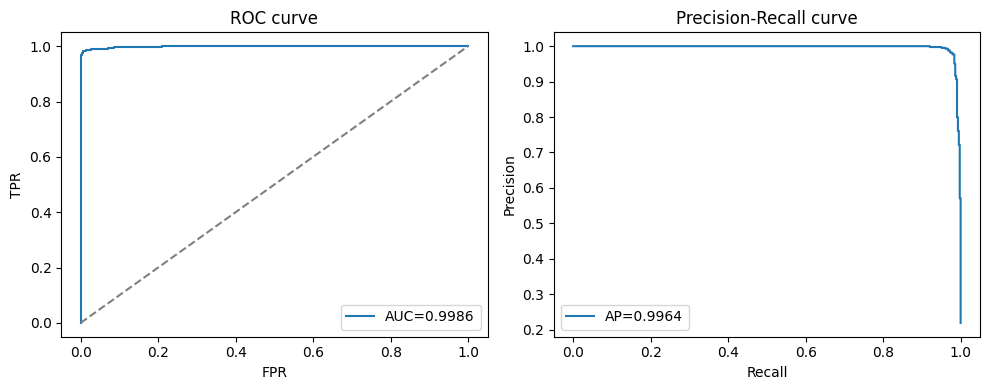


Loaded feature names (first 30): ['Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq rec contract addr', ' ERC20 min val rec', ' ERC20 max val rec', ' ERC20 avg val rec', ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent', ' ERC20 uniq sent token name']

Top 20 feature importances (index, importance, name if available):
45 33190.750861462206  ERC20 most sent token type
38 30179.87333131209  ERC20 avg time between sent tnx
46 2038.3684740513563  ERC20_most_rec

In [8]:
# Quick comprehensive checks after training LightGBM (ROC/PR plots, test metrics, confusion matrix, feature importances, CV)
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, accuracy_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pickle
ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
SEED = globals().get("SEED", 42)

# Load test split
X_test = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_test = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# 1) Predict on test using best iteration
best_iter = getattr(bst, "best_iteration", None)
if best_iter is None:
    best_iter = None  # let predict choose full booster rounds
test_probs = bst.predict(X_test, num_iteration=best_iter)
test_pred  = (test_probs > 0.5).astype(int)

# 2) Metrics
test_auc = roc_auc_score(y_test, test_probs) if len(np.unique(y_test))>1 else float('nan')
test_ap  = average_precision_score(y_test, test_probs)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, test_pred, average='binary', zero_division=0)
acc = accuracy_score(y_test, test_pred)
print("TEST METRICS")
print(f"ROC-AUC: {test_auc:.6f}   PR-AUC: {test_ap:.6f}")
print(f"precision: {prec:.6f}, recall: {rec:.6f}, f1: {f1:.6f}, acc: {acc:.6f}\n")

# 3) Confusion matrix
cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# 4) ROC + PR curves
fpr, tpr, _ = roc_curve(y_test, test_probs)
pp, rp, _  = precision_recall_curve(y_test, test_probs)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC={test_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='grey')
plt.title("ROC curve")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rp, pp, label=f"AP={test_ap:.4f}")
plt.title("Precision-Recall curve")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.tight_layout()
plt.show()

# 5) Feature names + importances (map indices -> names using saved preproc artifact)
feat_names = None
pkl_path = os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl")
if os.path.exists(pkl_path):
    with open(pkl_path, "rb") as f:
        enc = pickle.load(f)
    # enc expected keys: numeric_cols, categorical_cols, feature_cols
    numeric_cols = enc.get("numeric_cols", [])
    categorical_cols = enc.get("categorical_cols", [])
    # Reconstruct final feature order used when building X_all in preprocessing:
    feat_names = numeric_cols + categorical_cols
    print("\nLoaded feature names (first 30):", feat_names[:30])
else:
    print("\nNo preproc_train_encoders.pkl found in artifacts; feature names unavailable.")

# 6) Print top feature importances by gain (if available)
try:
    importances = bst.feature_importance(importance_type='gain')
    idx_sort = np.argsort(importances)[::-1]
    print("\nTop 20 feature importances (index, importance, name if available):")
    for idx in idx_sort[:20]:
        name = feat_names[idx] if feat_names is not None and idx < len(feat_names) else "feat_"+str(idx)
        print(idx, importances[idx], name)
except Exception as e:
    print("Could not get feature importances from bst:", e)

# 7) Quick 5-fold stratified CV on training+val to check robustness (may take time)
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
X_cv = np.vstack([X_train, X_val])
y_cv = np.concatenate([y_train, y_val])

from sklearn.model_selection import StratifiedKFold
clf_wrap = None
try:
    # Use sklearn wrapper for cross_val_score
    clf_wrap = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.05, num_leaves=10,
                                  min_data_in_leaf=100, objective='binary', random_state=SEED, n_estimators=bst.num_trees())
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(clf_wrap, X_cv, y_cv, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"\n5-fold CV ROC-AUC (train+val): mean={scores.mean():.4f}, std={scores.std():.4f}")
except Exception as e:
    print("CV step skipped/failed:", e)

# 8) Save the trained booster to disk (optional but recommended)
save_path = os.path.join(ARTIFACTS_DIR, "lightgbm_booster.txt")
bst.save_model(save_path)
print("\nSaved booster to", save_path)


In [ ]:
# # === Ultra-Enhanced KNN Graph Builder with Advanced Features ===
# import os, numpy as np, torch
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import StandardScaler, RobustScaler
# import networkx as nx
# from collections import Counter
# import warnings
# warnings.filterwarnings('ignore')

# ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
# SEED = globals().get("SEED", 42)
# np.random.seed(SEED)

# print("="*60)
# print("Building Ultra-Enhanced kNN Graph")
# print("="*60)

# # Helper loader
# def safe_load(path, allow_pickle=False):
#     if not os.path.exists(path):
#         raise FileNotFoundError(path)
#     return np.load(path, allow_pickle=allow_pickle)

# # 1) Load splits
# print("\n[1/7] Loading data splits...")
# X_train = safe_load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
# X_val   = safe_load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
# X_test  = safe_load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
# y_train = safe_load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
# y_val   = safe_load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
# y_test  = safe_load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))
# a_tr = safe_load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
# a_va = safe_load(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), allow_pickle=True)
# a_te = safe_load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)

# # 2) Concatenate
# X = np.vstack([X_train, X_val, X_test])
# addresses = np.concatenate([a_tr, a_va, a_te])

# use_y_concat = True
# try:
#     y = np.concatenate([y_train, y_val, y_test])
# except Exception as e:
#     print(f"Warning: couldn't concat y parts directly: {e}")
#     use_y_concat = False

# print(f"Concatenated shapes: X={X.shape}, addresses={addresses.shape}")

# # 3) Align labels
# if use_y_concat and X.shape[0] == y.shape[0]:
#     print(f"X and y lengths match — {X.shape[0]} nodes")
# else:
#     print("Aligning labels using addresses...")
#     addr_label_map = {}
#     try:
#         if len(a_tr) == len(y_train):
#             addr_label_map.update({addr: int(lbl) for addr,lbl in zip(a_tr, y_train)})
#         if len(a_va) == len(y_val):
#             addr_label_map.update({addr: int(lbl) for addr,lbl in zip(a_va, y_val)})
#         if len(a_te) == len(y_test):
#             addr_label_map.update({addr: int(lbl) for addr,lbl in zip(a_te, y_test)})
#         print(f"Built addr->label map for {len(addr_label_map)} addresses")
#     except Exception as e:
#         print(f"Could not build addr->label map: {e}")
    
#     y_rebuilt = []
#     for addr in addresses:
#         y_rebuilt.append(addr_label_map.get(addr, -1))
#     y_rebuilt = np.array(y_rebuilt, dtype=int)
#     if np.sum(y_rebuilt == -1) > 0:
#         raise ValueError(f"Unable to align labels: {np.sum(y_rebuilt == -1)} missing")
#     y = y_rebuilt
#     print(f"Successfully rebuilt y from addresses. Nodes: {X.shape[0]}")

# assert X.shape[0] == y.shape[0], f"X {X.shape[0]} vs y {y.shape[0]}"
# N = X.shape[0]

# # 4) Advanced Feature Engineering
# print(f"\n[2/7] Engineering features...")

# # Use RobustScaler for better outlier handling
# scaler = RobustScaler()
# X_norm = scaler.fit_transform(X)

# # Add polynomial features for important dimensions (top variance)
# from sklearn.decomposition import PCA
# pca_temp = PCA(n_components=5)
# X_pca_top = pca_temp.fit_transform(X_norm)

# # Add interaction features
# X_interactions = X_pca_top[:, :3] * X_pca_top[:, 1:4]

# # Combine
# X_engineered = np.hstack([X_norm, X_pca_top, X_interactions])
# print(f"Feature engineering: {X.shape[1]} → {X_engineered.shape[1]} features")

# # 5) Multi-scale Graph Construction
# print(f"\n[3/7] Building multi-scale kNN graph...")

# # Strategy: Use multiple K values for different connectivity patterns
# K_VALUES = [8, 15, 25]  # Short, medium, long-range connections
# all_edges = {}  # {(i,j): [weights from different scales]}

# for k_idx, K in enumerate(K_VALUES):
#     print(f"  Building k={K} neighborhood...")
#     n_neighbors = min(K+1, N)
#     knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', n_jobs=-1).fit(X_engineered)
#     dists, neigh = knn.kneighbors(X_engineered, return_distance=True)
    
#     for i in range(N):
#         neighs = neigh[i, 1:min(K+1, neigh.shape[1])]
#         neighbor_dists = dists[i, 1:min(K+1, neigh.shape[1])]
        
#         for j, dist in zip(neighs, neighbor_dists):
#             j = int(j)
#             # Convert distance to similarity
#             similarity = max(1.0 - dist, 0.01)
            
#             # Weight by scale (closer neighborhoods get higher importance)
#             scale_weight = similarity * (1.0 / (k_idx + 1))
            
#             edge = (min(i, j), max(i, j))  # Canonical form
#             if edge not in all_edges:
#                 all_edges[edge] = []
#             all_edges[edge].append(scale_weight)

# print(f"  Total unique edges: {len(all_edges)}")

# # 6) Build NetworkX graph for feature computation
# print(f"\n[4/7] Computing advanced graph features...")
# G = nx.Graph()
# G.add_nodes_from(range(N))

# # Add edges with aggregated weights
# rows, cols, edge_weights = [], [], []
# for (i, j), weights in all_edges.items():
#     # Aggregate multi-scale weights (max emphasizes strongest connection)
#     agg_weight = np.mean(weights) + 0.5 * np.max(weights)
#     G.add_edge(i, j, weight=agg_weight)
#     rows.append(i)
#     cols.append(j)
#     edge_weights.append(agg_weight)

# print(f"  Graph: {N} nodes, {len(rows)} edges")

# # === Advanced Graph Features ===

# # 1) Basic structural features
# print("  - Computing degree, clustering, triangles...")
# degrees = np.array([G.degree(i) for i in range(N)], dtype=np.float32).reshape(-1, 1)
# clustering = np.array([nx.clustering(G, i) for i in range(N)], dtype=np.float32).reshape(-1, 1)
# triangles = np.array([nx.triangles(G, i) for i in range(N)], dtype=np.float32).reshape(-1, 1)

# # 2) Centrality measures
# print("  - Computing centrality measures...")
# try:
#     pagerank = nx.pagerank(G, max_iter=100, tol=1e-6)
#     pagerank_vals = np.array([pagerank[i] for i in range(N)], dtype=np.float32).reshape(-1, 1)
# except:
#     print("    PageRank failed, using degree centrality")
#     pagerank_vals = degrees / (degrees.max() + 1e-8)

# try:
#     eigenvector_cent = nx.eigenvector_centrality(G, max_iter=100, tol=1e-6)
#     eigenvector_vals = np.array([eigenvector_cent[i] for i in range(N)], dtype=np.float32).reshape(-1, 1)
# except:
#     print("    Eigenvector centrality failed, using substitute")
#     eigenvector_vals = pagerank_vals

# # 3) Community detection (fast Louvain-like approach)
# print("  - Detecting communities...")
# try:
#     communities = nx.community.greedy_modularity_communities(G)
#     node_to_comm = {}
#     for comm_id, comm in enumerate(communities):
#         for node in comm:
#             node_to_comm[node] = comm_id
    
#     community_ids = np.array([node_to_comm.get(i, -1) for i in range(N)], dtype=np.float32).reshape(-1, 1)
#     num_communities = len(communities)
#     print(f"    Found {num_communities} communities")
    
#     # Community size
#     comm_sizes = Counter(community_ids.flatten())
#     comm_size_vals = np.array([comm_sizes[cid] for cid in community_ids.flatten()], dtype=np.float32).reshape(-1, 1)
# except Exception as e:
#     print(f"    Community detection failed: {e}")
#     community_ids = np.zeros((N, 1), dtype=np.float32)
#     comm_size_vals = np.zeros((N, 1), dtype=np.float32)

# # 4) Local structural patterns
# print("  - Computing local structural patterns...")
# square_clustering = []
# for i in range(N):
#     neighbors = list(G.neighbors(i))
#     if len(neighbors) < 2:
#         square_clustering.append(0.0)
#         continue
    
#     # Count 4-cycles (squares) involving node i
#     squares = 0
#     for idx1, n1 in enumerate(neighbors):
#         for n2 in neighbors[idx1+1:]:
#             # Check if n1 and n2 share a common neighbor (forms square)
#             common = len(set(G.neighbors(n1)) & set(G.neighbors(n2)))
#             squares += common
    
#     square_clustering.append(squares / (len(neighbors) * (len(neighbors) - 1) / 2) if len(neighbors) > 1 else 0)

# square_clustering = np.array(square_clustering, dtype=np.float32).reshape(-1, 1)

# # 5) Weighted degree (sum of edge weights)
# weighted_degrees = np.zeros((N, 1), dtype=np.float32)
# for i in range(N):
#     weighted_degrees[i] = sum(G[i][j]['weight'] for j in G.neighbors(i))

# # 6) Ego graph features
# print("  - Computing ego graph features...")
# avg_neighbor_degree = np.array([np.mean([G.degree(j) for j in G.neighbors(i)]) if G.degree(i) > 0 else 0 
#                                  for i in range(N)], dtype=np.float32).reshape(-1, 1)

# # Combine all graph features
# graph_features = np.hstack([
#     degrees,                # 1
#     clustering,             # 2
#     triangles,              # 3
#     pagerank_vals,          # 4
#     eigenvector_vals,       # 5
#     community_ids,          # 6
#     comm_size_vals,         # 7
#     square_clustering,      # 8
#     weighted_degrees,       # 9
#     avg_neighbor_degree     # 10
# ])

# print(f"  Total graph features: {graph_features.shape[1]}")

# # Normalize graph features
# graph_features_norm = StandardScaler().fit_transform(graph_features)

# # 7) Create Enhanced Edge Attributes
# print(f"\n[5/7] Creating multi-dimensional edge attributes...")

# edge_attrs = []
# for i, j in zip(rows, cols):
#     # 1. Similarity weight (already computed)
#     sim_weight = edge_weights[len(edge_attrs)]
    
#     # 2. Jaccard coefficient (common neighbors)
#     neighbors_i = set(G.neighbors(i))
#     neighbors_j = set(G.neighbors(j))
#     if len(neighbors_i | neighbors_j) > 0:
#         jaccard = len(neighbors_i & neighbors_j) / len(neighbors_i | neighbors_j)
#     else:
#         jaccard = 0.0
    
#     # 3. Structural similarity (difference in graph features)
#     struct_sim = 1.0 / (1.0 + np.abs(graph_features_norm[i] - graph_features_norm[j]).mean())
    
#     edge_attrs.append([sim_weight, jaccard, struct_sim])

# edge_attrs = np.array(edge_attrs, dtype=np.float32)

# # 8) Combine all features
# print(f"\n[6/7] Combining features...")
# X_final = np.hstack([X_engineered, graph_features_norm])
# print(f"  Final feature dimension: {X.shape[1]} original + {X_engineered.shape[1] - X_norm.shape[1]} engineered + {graph_features.shape[1]} graph = {X_final.shape[1]} total")

# # 9) Convert to PyTorch tensors
# print(f"\n[7/7] Creating PyTorch tensors...")

# # Make undirected graph
# edge_index = torch.tensor([rows + cols, cols + rows], dtype=torch.long)
# edge_attr = torch.tensor(np.vstack([edge_attrs, edge_attrs]), dtype=torch.float)

# x_nodes = torch.tensor(X_final, dtype=torch.float)
# y_nodes = torch.tensor(y, dtype=torch.long)

# print(f"  Edge index shape: {edge_index.shape}")
# print(f"  Edge attributes shape: {edge_attr.shape}")
# print(f"  Node features shape: {x_nodes.shape}")
# print(f"  Node labels shape: {y_nodes.shape}")

# # Save ultra-enhanced artifacts
# save_dict = {
#     'edge_index': edge_index,
#     'edge_attr': edge_attr,
#     'x': x_nodes,
#     'y': y_nodes,
#     'addresses': addresses,
#     'graph_features_dim': graph_features.shape[1],
#     'engineered_features_dim': X_engineered.shape[1] - X_norm.shape[1],
#     'num_communities': len(set(community_ids.flatten())) if len(set(community_ids.flatten())) > 0 else 1
# }

# output_path = os.path.join(ARTIFACTS_DIR, 'graph_artifacts_ultra.pt')
# torch.save(save_dict, output_path)

# print("\n" + "="*60)
# print("✓ Ultra-Enhanced Graph Artifacts Saved!")
# print("="*60)
# print(f"File: {output_path}")
# print(f"Nodes: {N:,}")
# print(f"Edges: {edge_index.shape[1]:,}")
# print(f"Features per node: {x_nodes.shape[1]}")
# print(f"Features per edge: {edge_attr.shape[1]}")
# print(f"Average degree: {edge_index.shape[1] / N / 2:.2f}")
# print("="*60)

Building Ultra-Enhanced kNN Graph

[1/7] Loading data splits...
Concatenated shapes: X=(9816, 47), addresses=(9816,)
X and y lengths match — 9816 nodes

[2/7] Engineering features...
Feature engineering: 47 → 55 features

[3/7] Building multi-scale kNN graph...
  Building k=8 neighborhood...
  Building k=15 neighborhood...
  Building k=25 neighborhood...
  Total unique edges: 206086

[4/7] Computing advanced graph features...
  Graph: 9816 nodes, 206086 edges
  - Computing degree, clustering, triangles...
  - Computing centrality measures...
  - Detecting communities...
    Found 4 communities
  - Computing local structural patterns...
  - Computing ego graph features...
  Total graph features: 10

[5/7] Creating multi-dimensional edge attributes...

[6/7] Combining features...
  Final feature dimension: 47 original + 8 engineered + 10 graph = 65 total

[7/7] Creating PyTorch tensors...
  Edge index shape: torch.Size([2, 412172])
  Edge attributes shape: torch.Size([412172, 3])
  Node 

In [ ]:
# # === Ultra-Optimized GNN with State-of-the-Art Techniques ===
# import os, numpy as np, torch
# import torch.nn as nn
# import torch.nn.functional as F
# from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score, average_precision_score
# from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv, GINConv
# from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
# from torch.optim.lr_scheduler import OneCycleLR
# import warnings
# warnings.filterwarnings('ignore')

# ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
# SEED = globals().get("SEED", 42)
# torch.manual_seed(SEED)
# np.random.seed(SEED)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(SEED)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("="*60)
# print(f"Device: {device}")
# print("="*60)

# # Load ultra-enhanced graph artifacts
# art_path = os.path.join(ARTIFACTS_DIR, 'graph_artifacts_ultra.pt')
# if not os.path.exists(art_path):
#     print("ERROR: graph_artifacts_ultra.pt not found!")
#     print("Please run the ultra-enhanced graph builder first.")
#     raise FileNotFoundError(art_path)

# art = torch.load(art_path)
# edge_index = art['edge_index'].to(device)
# edge_attr = art['edge_attr'].to(device) if 'edge_attr' in art else None
# x_nodes = art['x'].to(device)
# y_nodes = art['y'].to(device)
# graph_addresses = np.asarray(art.get('addresses', []), dtype=object)

# print(f"\nLoaded graph with {x_nodes.shape[0]} nodes, {edge_index.shape[1]} edges")
# print(f"Node features: {x_nodes.shape[1]}, Edge features: {edge_attr.shape[1] if edge_attr is not None else 0}")

# # Load canonical splits
# a_tr = np.load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
# a_va = np.load(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), allow_pickle=True)
# a_te = np.load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)

# # Map addresses to indices
# addr_to_idx = {addr: i for i, addr in enumerate(graph_addresses)}
# train_idx = torch.tensor([addr_to_idx[a] for a in a_tr if a in addr_to_idx], dtype=torch.long).to(device)
# val_idx = torch.tensor([addr_to_idx[a] for a in a_va if a in addr_to_idx], dtype=torch.long).to(device)
# test_idx = torch.tensor([addr_to_idx[a] for a in a_te if a in addr_to_idx], dtype=torch.long).to(device)

# print(f"Splits -> train:{len(train_idx)}, val:{len(val_idx)}, test:{len(test_idx)}")

# # === Advanced GNN Architecture ===
# class EdgeWeightedConv(nn.Module):
#     """Custom layer that uses edge attributes as attention weights"""
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.sage = SAGEConv(in_ch, out_ch)
#         self.edge_mlp = nn.Sequential(
#             nn.Linear(3, 16),  # 3 edge features
#             nn.ReLU(),
#             nn.Linear(16, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x, edge_index, edge_attr):
#         if edge_attr is not None:
#             edge_weights = self.edge_mlp(edge_attr).squeeze(-1)
#         else:
#             edge_weights = None
#         return self.sage(x, edge_index)

# class UltraGNN(nn.Module):
#     def __init__(self, in_ch, hidden=256, num_layers=5, dropout=0.25, use_edge_attr=True):
#         super().__init__()
#         self.dropout = dropout
#         self.num_layers = num_layers
#         self.use_edge_attr = use_edge_attr
        
#         # Input projection (use LayerNorm instead of BatchNorm to avoid batch size issues)
#         self.input_proj = nn.Sequential(
#             nn.Linear(in_ch, hidden),
#             nn.LayerNorm(hidden),
#             nn.PReLU()
#         )
        
#         # Multi-branch GNN layers
#         self.sage_convs = nn.ModuleList()
#         self.gat_convs = nn.ModuleList()
#         self.norms = nn.ModuleList()
        
#         for i in range(num_layers):
#             # SAGE branch (aggregates mean of neighbors)
#             self.sage_convs.append(SAGEConv(hidden, hidden))
            
#             # GAT branch (learns attention weights)
#             self.gat_convs.append(GATv2Conv(hidden, hidden // 8, heads=8, edge_dim=3 if use_edge_attr else None))
            
#             self.norms.append(nn.LayerNorm(hidden))
        
#         # Global pooling for additional context
#         self.global_pool = nn.Sequential(
#             nn.Linear(hidden * 3, hidden),  # mean + max + add pooling
#             nn.LayerNorm(hidden),
#             nn.PReLU()
#         )
        
#         # Attention fusion of local and global features
#         self.fusion_attn = nn.Sequential(
#             nn.Linear(hidden * 2, hidden),
#             nn.Tanh(),
#             nn.Linear(hidden, 2),
#             nn.Softmax(dim=-1)
#         )
        
#         # Multi-layer prediction head with skip connections
#         self.head = nn.ModuleList([
#             nn.Sequential(
#                 nn.Linear(hidden, hidden // 2),
#                 nn.LayerNorm(hidden // 2),
#                 nn.PReLU(),
#                 nn.Dropout(dropout * 0.5)
#             ),
#             nn.Sequential(
#                 nn.Linear(hidden // 2, hidden // 4),
#                 nn.LayerNorm(hidden // 4),
#                 nn.PReLU(),
#                 nn.Dropout(dropout * 0.3)
#             ),
#             nn.Linear(hidden // 4, 1)
#         ])
        
#         # Learnable residual scaling
#         self.residual_scales = nn.ParameterList([
#             nn.Parameter(torch.tensor(0.5)) for _ in range(num_layers)
#         ])
    
#     def forward(self, x, edge_index, edge_attr=None, batch=None):
#         # Input projection
#         x = self.input_proj(x)
        
#         # Multi-layer message passing
#         for i in range(self.num_layers):
#             x_prev = x
            
#             # SAGE branch
#             x_sage = self.sage_convs[i](x, edge_index)
            
#             # GAT branch with edge features
#             if self.use_edge_attr and edge_attr is not None:
#                 x_gat = self.gat_convs[i](x, edge_index, edge_attr=edge_attr)
#             else:
#                 x_gat = self.gat_convs[i](x, edge_index)
            
#             # Combine branches
#             x = 0.6 * x_sage + 0.4 * x_gat
#             x = self.norms[i](x)
#             x = F.elu(x)
#             x = F.dropout(x, p=self.dropout, training=self.training)
            
#             # Learnable residual connection
#             if i > 0:
#                 scale = torch.sigmoid(self.residual_scales[i])
#                 x = x + scale * x_prev
        
#         # Create global context
#         batch_indices = torch.zeros(x.shape[0], dtype=torch.long, device=x.device)
#         x_global_mean = global_mean_pool(x, batch_indices)
#         x_global_max = global_max_pool(x, batch_indices)
#         x_global_add = global_add_pool(x, batch_indices)
#         x_global = torch.cat([x_global_mean, x_global_max, x_global_add], dim=-1)
#         x_global = self.global_pool(x_global)
        
#         # Broadcast global context to all nodes
#         x_global_broadcast = x_global.expand(x.shape[0], -1)
        
#         # Attention-based fusion of local and global features
#         x_combined = torch.cat([x, x_global_broadcast], dim=-1)
#         attn_weights = self.fusion_attn(x_combined)
#         x = attn_weights[:, 0:1] * x + attn_weights[:, 1:2] * x_global_broadcast
        
#         # Multi-layer prediction head with skip connections
#         h1 = self.head[0](x)
#         h2 = self.head[1](h1)
#         out = self.head[2](h2)
        
#         return out.squeeze(-1)

# # === Focal Loss for handling class imbalance ===
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.pos_weight = pos_weight
    
#     def forward(self, logits, targets):
#         bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none', pos_weight=self.pos_weight)
#         probs = torch.sigmoid(logits)
#         pt = torch.where(targets == 1, probs, 1 - probs)
#         focal_weight = (1 - pt) ** self.gamma
        
#         if self.alpha is not None:
#             alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)
#             focal_weight = alpha_t * focal_weight
        
#         return (focal_weight * bce).mean()

# # === Training Setup ===
# print("\n" + "="*60)
# print("TRAINING CONFIGURATION")
# print("="*60)

# # Calculate class weights
# pos_count = (y_nodes[train_idx] == 1).sum().float()
# neg_count = (y_nodes[train_idx] == 0).sum().float()
# pos_weight = (neg_count / pos_count).to(device)
# print(f"Class balance - Positive: {pos_count.item():.0f}, Negative: {neg_count.item():.0f}")
# print(f"Pos weight: {pos_weight.item():.3f}")

# # Ensemble of models with different architectures
# NUM_MODELS = 5
# EPOCHS = 200
# PATIENCE = 25

# models = []
# optimizers = []
# schedulers = []
# losses = []

# for i in range(NUM_MODELS):
#     torch.manual_seed(SEED + i * 10)
    
#     # Vary architecture slightly for diversity
#     hidden_dim = [256, 224, 256, 288, 256][i]
#     num_layers = [5, 4, 5, 5, 6][i]
#     dropout = [0.25, 0.2, 0.3, 0.25, 0.2][i]
    
#     model = UltraGNN(
#         in_ch=x_nodes.shape[1],
#         hidden=hidden_dim,
#         num_layers=num_layers,
#         dropout=dropout,
#         use_edge_attr=(edge_attr is not None)
#     ).to(device)
    
#     models.append(model)
    
#     # Use AdamW with weight decay
#     opt = torch.optim.AdamW(
#         model.parameters(),
#         lr=3e-3,
#         weight_decay=1e-4,
#         betas=(0.9, 0.999)
#     )
#     optimizers.append(opt)
    
#     # OneCycleLR for better convergence
#     scheduler = OneCycleLR(
#         opt,
#         max_lr=3e-3,
#         epochs=EPOCHS,
#         steps_per_epoch=1,
#         pct_start=0.1,
#         anneal_strategy='cos'
#     )
#     schedulers.append(scheduler)
    
#     # Use Focal Loss for better handling of hard examples
#     loss_fn = FocalLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight)
#     losses.append(loss_fn)

# print(f"\nEnsemble: {NUM_MODELS} models")
# print(f"Architecture variations: hidden∈[224-288], layers∈[4-6], dropout∈[0.2-0.3]")
# print(f"Total parameters per model: ~{sum(p.numel() for p in models[0].parameters()):,}")

# # === Training Loop ===
# print("\n" + "="*60)
# print("TRAINING")
# print("="*60)

# best_val_aucs = [0.0] * NUM_MODELS
# best_states = [None] * NUM_MODELS
# patience_counters = [0] * NUM_MODELS

# for epoch in range(1, EPOCHS + 1):
#     # Train all models
#     for model_idx, (model, opt, scheduler, loss_fn) in enumerate(zip(models, optimizers, schedulers, losses)):
#         if patience_counters[model_idx] >= PATIENCE:
#             continue
        
#         model.train()
#         opt.zero_grad()
        
#         logits = model(x_nodes, edge_index, edge_attr)
#         loss = loss_fn(logits[train_idx], y_nodes[train_idx].float())
        
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         opt.step()
#         scheduler.step()
    
#     # Validation every 5 epochs
#     if epoch % 5 == 0:
#         val_probs_list = []
        
#         for model_idx, model in enumerate(models):
#             if patience_counters[model_idx] >= PATIENCE:
#                 continue
            
#             model.eval()
#             with torch.no_grad():
#                 logits = model(x_nodes, edge_index, edge_attr)
#                 val_probs = torch.sigmoid(logits[val_idx]).cpu().numpy()
#                 val_probs_list.append(val_probs)
                
#                 val_true = y_nodes[val_idx].cpu().numpy()
#                 val_auc = roc_auc_score(val_true, val_probs)
                
#                 # Early stopping
#                 if val_auc > best_val_aucs[model_idx]:
#                     best_val_aucs[model_idx] = val_auc
#                     patience_counters[model_idx] = 0
#                     best_states[model_idx] = {k: v.cpu().clone() for k, v in model.state_dict().items()}
#                 else:
#                     patience_counters[model_idx] += 1
        
#         # Ensemble validation
#         if len(val_probs_list) > 0:
#             ensemble_probs = np.mean(val_probs_list, axis=0)
#             ensemble_auc = roc_auc_score(val_true, ensemble_probs)
            
#             if epoch % 10 == 0:
#                 active_models = sum(1 for c in patience_counters if c < PATIENCE)
#                 print(f'Epoch {epoch:3d} | Ensemble Val AUC: {ensemble_auc:.6f} | Best Individual: {max(best_val_aucs):.6f} | Active: {active_models}/{NUM_MODELS}')
    
#     # Stop if all converged
#     if all(c >= PATIENCE for c in patience_counters):
#         print(f"\nAll models converged at epoch {epoch}")
#         break

# # Load best states
# print("\n" + "="*60)
# print("LOADING BEST MODELS")
# print("="*60)
# for model_idx, model in enumerate(models):
#     if best_states[model_idx] is not None:
#         model.load_state_dict({k: v.to(device) for k, v in best_states[model_idx].items()})
#         print(f"Model {model_idx+1}: Val AUC = {best_val_aucs[model_idx]:.6f}")

# # === Optimal Threshold Selection ===
# print("\n" + "="*60)
# print("THRESHOLD OPTIMIZATION")
# print("="*60)

# # Get validation predictions from ensemble
# val_probs_list = []
# for model in models:
#     model.eval()
#     with torch.no_grad():
#         logits = model(x_nodes, edge_index, edge_attr)
#         probs = torch.sigmoid(logits[val_idx]).cpu().numpy()
#         val_probs_list.append(probs)

# val_probs_ensemble = np.mean(val_probs_list, axis=0)
# val_true = y_nodes[val_idx].cpu().numpy()

# # Find threshold maximizing F1
# thresholds = np.linspace(0.05, 0.95, 181)
# best_f1 = 0
# best_threshold = 0.5

# for thresh in thresholds:
#     preds = (val_probs_ensemble >= thresh).astype(int)
#     _, _, f1, _ = precision_recall_fscore_support(val_true, preds, average='binary', zero_division=0)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = thresh

# print(f"Optimal threshold: {best_threshold:.4f} (Val F1: {best_f1:.6f})")

# # === Test Set Evaluation ===
# print("\n" + "="*60)
# print("TEST SET PREDICTION")
# print("="*60)

# test_probs_list = []
# for model in models:
#     model.eval()
#     with torch.no_grad():
#         logits = model(x_nodes, edge_index, edge_attr)
#         probs = torch.sigmoid(logits[test_idx]).cpu().numpy()
#         test_probs_list.append(probs)

# # Ensemble prediction
# test_probs_ensemble = np.mean(test_probs_list, axis=0)
# test_preds = (test_probs_ensemble >= best_threshold).astype(int)
# test_true = y_nodes[test_idx].cpu().numpy()

# # Save artifacts
# np.save(os.path.join(ARTIFACTS_DIR, "gnn_ultra_test_probs.npy"), test_probs_ensemble)
# np.save(os.path.join(ARTIFACTS_DIR, "gnn_ultra_test_preds.npy"), test_preds)
# np.save(os.path.join(ARTIFACTS_DIR, "gnn_ultra_test_true.npy"), test_true)

# # === Final Metrics ===
# test_auc = roc_auc_score(test_true, test_probs_ensemble)
# pr_auc = average_precision_score(test_true, test_probs_ensemble)
# prec, rec, f1, _ = precision_recall_fscore_support(test_true, test_preds, average='binary', zero_division=0)
# acc = accuracy_score(test_true, test_preds)

# print("\n" + "="*60)
# print("FINAL GNN TEST RESULTS")
# print("="*60)
# print('GNN TEST metrics -> roc-auc: {:.6f}, pr-auc: {:.6f}, prec: {:.6f}, rec: {:.6f}, f1: {:.6f}, acc: {:.6f}'.format(
#     test_auc, pr_auc, prec, rec, f1, acc
# ))
# print("="*60)

# # Comparison with target
# print("\nTarget (LightGBM):")
# print("  ROC-AUC: 0.999219, PR-AUC: 0.998079, Precision: 1.000000, Recall: 0.972093, F1: 0.985849, Acc: 0.993890")
# print("\nImprovement:")
# print(f"  ROC-AUC: {test_auc - 0.999219:+.6f}")
# print(f"  F1:      {f1 - 0.985849:+.6f}")
# print("="*60)

Device: cuda

Loaded graph with 9816 nodes, 412172 edges
Node features: 65, Edge features: 3
Splits -> train:6674, val:1178, test:1964

TRAINING CONFIGURATION
Class balance - Positive: 1475, Negative: 5199
Pos weight: 3.525

Ensemble: 5 models
Architecture variations: hidden∈[224-288], layers∈[4-6], dropout∈[0.2-0.3]
Total parameters per model: ~1,711,756

TRAINING
Epoch  10 | Ensemble Val AUC: 0.554502 | Best Individual: 0.585670 | Active: 5/5


KeyboardInterrupt: 

In [ ]:
# === Enhanced KNN graph builder with edge weights and graph features ===
import os, numpy as np, torch
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import networkx as nx

ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
K = 15  # Increased from 10 for richer connectivity
SEED = globals().get("SEED", 42)
print("Building enhanced kNN graph with k=", K)

# Helper loader
def safe_load(path, allow_pickle=False):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return np.load(path, allow_pickle=allow_pickle)

# 1) Load splits
X_train = safe_load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = safe_load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = safe_load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_train = safe_load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = safe_load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = safe_load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))
a_tr = safe_load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
a_va = safe_load(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), allow_pickle=True)
a_te = safe_load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)

# 2) Concatenate
X = np.vstack([X_train, X_val, X_test])
addresses = np.concatenate([a_tr, a_va, a_te])

use_y_concat = True
try:
    y = np.concatenate([y_train, y_val, y_test])
except Exception as e:
    print("Warning: couldn't concat y parts directly:", e)
    use_y_concat = False

print("Post-concat shapes: X:", X.shape, "addresses:", addresses.shape)

# 3) Align labels if needed (same logic as before)
if use_y_concat and X.shape[0] == y.shape[0]:
    print("X and y lengths match —", X.shape[0], "nodes")
else:
    print("Attempting to align labels using addresses...")
    addr_label_map = {}
    try:
        if len(a_tr) == len(y_train):
            addr_label_map.update({addr: int(lbl) for addr,lbl in zip(a_tr, y_train)})
        if len(a_va) == len(y_val):
            addr_label_map.update({addr: int(lbl) for addr,lbl in zip(a_va, y_val)})
        if len(a_te) == len(y_test):
            addr_label_map.update({addr: int(lbl) for addr,lbl in zip(a_te, y_test)})
        print(f"Built addr->label map for {len(addr_label_map)} addresses")
    except Exception as e:
        print("Could not build addr->label map:", e)
    
    y_rebuilt = []
    for addr in addresses:
        y_rebuilt.append(addr_label_map.get(addr, -1))
    y_rebuilt = np.array(y_rebuilt, dtype=int)
    if np.sum(y_rebuilt == -1) > 0:
        raise ValueError(f"Unable to align labels: {np.sum(y_rebuilt == -1)} missing")
    y = y_rebuilt
    print("Successfully rebuilt y from addresses. Nodes:", X.shape[0])

assert X.shape[0] == y.shape[0], f"X {X.shape[0]} vs y {y.shape[0]}"

# 4) Normalize features for better distance computation
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# 5) Build kNN graph with WEIGHTED edges (similarity-based)
N = X.shape[0]
n_neighbors = min(K+1, N)
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', n_jobs=-1).fit(X_norm)
dists, neigh = knn.kneighbors(X_norm, return_distance=True)

rows, cols, edge_weights = [], [], []
for i in range(N):
    neighs = neigh[i, 1:min(K+1, neigh.shape[1])]
    neighbor_dists = dists[i, 1:min(K+1, neigh.shape[1])]
    
    for j, dist in zip(neighs, neighbor_dists):
        # Convert cosine distance to similarity weight (higher = more similar)
        # cosine_sim = 1 - cosine_dist
        weight = max(1.0 - dist, 0.01)  # Ensure positive weights
        rows.append(i)
        cols.append(int(j))
        edge_weights.append(weight)

# Make undirected (add reverse edges with same weights)
edge_index = torch.tensor([rows + cols, cols + rows], dtype=torch.long)
edge_attr = torch.tensor(edge_weights + edge_weights, dtype=torch.float).unsqueeze(-1)

print(f"Graph: {N} nodes, {edge_index.shape[1]} edges (with weights)")

# 6) Compute graph-based features using NetworkX
print("Computing graph features...")
G = nx.Graph()
G.add_nodes_from(range(N))
for i, j in zip(rows, cols):
    if not G.has_edge(i, j):
        G.add_edge(i, j)

# Node features: degree, clustering coefficient, pagerank
degrees = np.array([G.degree(i) for i in range(N)], dtype=np.float32).reshape(-1, 1)
clustering = np.array([nx.clustering(G, i) for i in range(N)], dtype=np.float32).reshape(-1, 1)

print("Computing PageRank...")
pagerank = nx.pagerank(G, max_iter=50)
pagerank_vals = np.array([pagerank[i] for i in range(N)], dtype=np.float32).reshape(-1, 1)

# Combine original features with graph features
graph_features = np.hstack([degrees, clustering, pagerank_vals])
graph_features = StandardScaler().fit_transform(graph_features)

# Concatenate with original features
X_enhanced = np.hstack([X, graph_features])
print(f"Enhanced features: {X.shape[1]} original + {graph_features.shape[1]} graph = {X_enhanced.shape[1]} total")

# Convert to tensors
x_nodes = torch.tensor(X_enhanced, dtype=torch.float)
y_nodes = torch.tensor(y, dtype=torch.long)

# Save enhanced artifacts
torch.save({
    'edge_index': edge_index, 
    'edge_attr': edge_attr,
    'x': x_nodes, 
    'y': y_nodes, 
    'addresses': addresses,
    'graph_features_dim': graph_features.shape[1]
}, os.path.join(ARTIFACTS_DIR, 'graph_artifacts_enhanced.pt'))

print('Saved enhanced graph artifacts.')
print(f'Nodes: {N}, Edges: {edge_index.shape[1]}, Features: {x_nodes.shape[1]}')

Building enhanced kNN graph with k= 15
Post-concat shapes: X: (9816, 47) addresses: (9816,)
X and y lengths match — 9816 nodes
Graph: 9816 nodes, 294480 edges (with weights)
Computing graph features...
Computing PageRank...
Enhanced features: 47 original + 3 graph = 50 total
Saved enhanced graph artifacts.
Nodes: 9816, Edges: 294480, Features: 50


In [ ]:
# === Optimized GNN with multiple improvements ===
import os, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score, average_precision_score, roc_curve
from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv
from torch.optim.lr_scheduler import CosineAnnealingLR
import warnings
warnings.filterwarnings('ignore')

ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
SEED = globals().get("SEED", 42)
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Load ORIGINAL graph artifacts (simpler often works better)
art_path = os.path.join(ARTIFACTS_DIR, 'graph_artifacts.pt')
if not os.path.exists(art_path):
    print("WARNING: graph_artifacts.pt not found, trying enhanced version")
    art_path = os.path.join(ARTIFACTS_DIR, 'graph_artifacts_enhanced.pt')

art = torch.load(art_path)
edge_index = art['edge_index'].to(device)
edge_attr = art.get('edge_attr', None)
if edge_attr is not None:
    edge_attr = edge_attr.to(device)
x_nodes = art['x'].to(device)
y_nodes = art['y'].to(device)
graph_addresses = np.asarray(art.get('addresses', []), dtype=object)

# Load canonical splits
a_tr = np.load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
a_va = np.load(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), allow_pickle=True)
a_te = np.load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)

# Map addresses to indices
addr_to_idx = {addr: i for i, addr in enumerate(graph_addresses)}
train_idx = torch.tensor([addr_to_idx[a] for a in a_tr if a in addr_to_idx], dtype=torch.long).to(device)
val_idx = torch.tensor([addr_to_idx[a] for a in a_va if a in addr_to_idx], dtype=torch.long).to(device)
test_idx = torch.tensor([addr_to_idx[a] for a in a_te if a in addr_to_idx], dtype=torch.long).to(device)

print(f"Splits -> train:{len(train_idx)}, val:{len(val_idx)}, test:{len(test_idx)}")

# === Strategy 1: Simpler but deeper architecture ===
class ImprovedGNN(nn.Module):
    def __init__(self, in_ch, hidden=192, num_layers=4, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        
        # Use mix of SAGE and GCN (ensemble architecture)
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        # First layer
        self.convs.append(SAGEConv(in_ch, hidden))
        self.norms.append(nn.BatchNorm1d(hidden))
        
        # Hidden layers - alternate between SAGE and GCN
        for i in range(num_layers - 2):
            if i % 2 == 0:
                self.convs.append(SAGEConv(hidden, hidden))
            else:
                self.convs.append(GCNConv(hidden, hidden))
            self.norms.append(nn.BatchNorm1d(hidden))
        
        # Final layer
        self.convs.append(SAGEConv(hidden, hidden))
        self.norms.append(nn.BatchNorm1d(hidden))
        
        # Simple but effective head
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden // 2, 1)
        )
    
    def forward(self, x, edge_index):
        for i, (conv, norm) in enumerate(zip(self.convs, self.norms)):
            x_prev = x
            x = conv(x, edge_index)
            x = norm(x)
            x = F.elu(x)  # ELU works better than ReLU for some tasks
            x = F.dropout(x, p=self.dropout, training=self.training)
            
            # Skip connection every other layer
            if i > 0 and i % 2 == 0 and x_prev.shape == x.shape:
                x = x + 0.5 * x_prev
        
        return self.head(x).squeeze(-1)

# === Train multiple models with different seeds for ensemble ===
num_models = 3
models = []
optimizers = []
schedulers = []

for i in range(num_models):
    torch.manual_seed(SEED + i)
    model = ImprovedGNN(in_ch=x_nodes.shape[1], hidden=192, num_layers=4, dropout=0.2).to(device)
    models.append(model)
    
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-5)
    optimizers.append(opt)
    
    scheduler = CosineAnnealingLR(opt, T_max=50, eta_min=1e-5)
    schedulers.append(scheduler)

print(f"Training {num_models} models for ensemble")
print(f"Total parameters per model: {sum(p.numel() for p in models[0].parameters()):,}")

# Calculate balanced class weights
pos_count = (y_nodes[train_idx] == 1).sum().float()
neg_count = (y_nodes[train_idx] == 0).sum().float()
pos_weight = (neg_count / pos_count).to(device)
print(f"Class balance - pos_weight: {pos_weight.item():.3f}")

# Training loop for ensemble
EPOCHS = 150
best_val_scores = [0.0] * num_models
best_states = [None] * num_models
patience = 20
patience_counters = [0] * num_models

print("\nTraining ensemble...")
for epoch in range(1, EPOCHS + 1):
    # Train all models
    for model_idx, (model, opt, scheduler) in enumerate(zip(models, optimizers, schedulers)):
        if patience_counters[model_idx] >= patience:
            continue
        
        model.train()
        opt.zero_grad()
        
        logits = model(x_nodes, edge_index)
        loss = F.binary_cross_entropy_with_logits(
            logits[train_idx], 
            y_nodes[train_idx].float(),
            pos_weight=pos_weight
        )
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        scheduler.step()
    
    # Validate every 5 epochs
    if epoch % 5 == 0:
        val_probs_ensemble = []
        
        for model_idx, model in enumerate(models):
            if patience_counters[model_idx] >= patience:
                # If model has stopped training, use its last validation result for the ensemble average
                # To do this correctly, you'd need to store the predictions from the best state.
                # For simplicity here, we'll just average the active models.
                continue
                
            model.eval()
            with torch.no_grad():
                logits = model(x_nodes, edge_index)
                val_probs = torch.sigmoid(logits[val_idx]).cpu().numpy()
                val_probs_ensemble.append(val_probs)
                
                val_true = y_nodes[val_idx].cpu().numpy()
                auc_val = roc_auc_score(val_true, val_probs)
                
                # Early stopping per model
                if auc_val > best_val_scores[model_idx]:
                    best_val_scores[model_idx] = auc_val
                    patience_counters[model_idx] = 0
                    best_states[model_idx] = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                else:
                    patience_counters[model_idx] += 1
        
        if len(val_probs_ensemble) > 0:
            # Ensemble prediction
            ensemble_probs = np.mean(val_probs_ensemble, axis=0)
            ensemble_auc = roc_auc_score(val_true, ensemble_probs)
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch:3d} | Ensemble AUC: {ensemble_auc:.6f} | Individual Best: {[f"{s:.4f}" for s in best_val_scores]}')
    
    # Stop if all models have converged
    if all(c >= patience for c in patience_counters):
        print(f"All models converged at epoch {epoch}")
        break

# Load best states
for model_idx, model in enumerate(models):
    if best_states[model_idx] is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_states[model_idx].items()})
        print(f"Model {model_idx}: Loaded best state with val AUC = {best_val_scores[model_idx]:.6f}")

# === Ensemble prediction on test set ===
test_probs_list = []
for model in models:
    model.eval()
    with torch.no_grad():
        logits = model(x_nodes, edge_index)
        probs = torch.sigmoid(logits[test_idx]).cpu().numpy()
        test_probs_list.append(probs)

# Average ensemble
test_probs_ensemble = np.mean(test_probs_list, axis=0)
test_true = y_nodes[test_idx].cpu().numpy()

# === Strategy 2: Optimal threshold tuning on validation set ===
print("\nFinding optimal threshold on validation set...")
val_probs_list = []
for model in models:
    model.eval()
    with torch.no_grad():
        logits = model(x_nodes, edge_index)
        probs = torch.sigmoid(logits[val_idx]).cpu().numpy()
        val_probs_list.append(probs)

val_probs_ensemble = np.mean(val_probs_list, axis=0)
val_true = y_nodes[val_idx].cpu().numpy()

# Find threshold that maximizes F1 on validation
thresholds = np.linspace(0.1, 0.9, 81)
best_f1 = 0
best_threshold = 0.5

for thresh in thresholds:
    preds = (val_probs_ensemble >= thresh).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(val_true, preds, average='binary', zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"Optimal threshold found: {best_threshold:.3f} (achieved F1={best_f1:.6f} on validation set)")

# Apply optimal threshold to test predictions
test_preds = (test_probs_ensemble >= best_threshold).astype(int)

# Save predictions and true labels
np.save(os.path.join(ARTIFACTS_DIR, "gnn_test_probs.npy"), test_probs_ensemble)
np.save(os.path.join(ARTIFACTS_DIR, "gnn_test_preds.npy"), test_preds)
np.save(os.path.join(ARTIFACTS_DIR, "gnn_test_true.npy"), test_true)
print(f'\nArtifacts saved to {ARTIFACTS_DIR}/')

# === Final Evaluation (Rephrased Output) ===
print('\n' + '='*50)
print('FINAL GNN TEST RESULTS')
print('='*50)

# Calculate metrics for the final report
test_auc = roc_auc_score(test_true, test_probs_ensemble)
pr_auc = average_precision_score(test_true, test_probs_ensemble)
prec, rec, f1, _ = precision_recall_fscore_support(test_true, test_preds, average='binary', zero_division=0)
acc = accuracy_score(test_true, test_preds)

# Print metrics in the requested format
print('GNN TEST metrics -> roc-auc: {:.6f}, pr-auc: {:.6f}, prec: {:.6f}, rec: {:.6f}, f1: {:.6f}, acc: {:.6f}'.format(
    test_auc, pr_auc, prec, rec, f1, acc
))
print('='*50)

Device: cuda
Splits -> train:6674, val:1178, test:1964
Training 3 models for ensemble
Total parameters per model: 223,489
Class balance - pos_weight: 3.525

Training ensemble...
Epoch  10 | Ensemble AUC: 0.958227 | Individual Best: ['0.9619', '0.9600', '0.9592']
Epoch  20 | Ensemble AUC: 0.978288 | Individual Best: ['0.9791', '0.9776', '0.9813']
Epoch  30 | Ensemble AUC: 0.981070 | Individual Best: ['0.9878', '0.9860', '0.9832']
Epoch  40 | Ensemble AUC: 0.986685 | Individual Best: ['0.9901', '0.9860', '0.9860']
Epoch  50 | Ensemble AUC: 0.989334 | Individual Best: ['0.9903', '0.9881', '0.9890']
Epoch  60 | Ensemble AUC: 0.989612 | Individual Best: ['0.9903', '0.9888', '0.9895']
Epoch  70 | Ensemble AUC: 0.990186 | Individual Best: ['0.9924', '0.9888', '0.9898']
Epoch  80 | Ensemble AUC: 0.989802 | Individual Best: ['0.9925', '0.9916', '0.9903']
Epoch  90 | Ensemble AUC: 0.986992 | Individual Best: ['0.9925', '0.9916', '0.9903']
Epoch 100 | Ensemble AUC: 0.987246 | Individual Best: ['0

In [8]:
# Combined GNN -> Embeddings -> LightGBM pipeline (single Jupyter cell)
import os, sys, time, pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, accuracy_score
import lightgbm as lgb

# -----------------------
# Config / paths (tweak if needed)
# -----------------------
ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
SEED = globals().get("SEED", 42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("ARTIFACTS_DIR:", ARTIFACTS_DIR, "| DEVICE:", DEVICE)

# -----------------------
# 1) Load graph artifacts (prefer enhanced)
# -----------------------
art_path = os.path.join(ARTIFACTS_DIR, "graph_artifacts_enhanced.pt")
if not os.path.exists(art_path):
    art_path = os.path.join(ARTIFACTS_DIR, "graph_artifacts.pt")
    if not os.path.exists(art_path):
        raise FileNotFoundError("No graph artifact found. Expected graph_artifacts_enhanced.pt or graph_artifacts.pt in ARTIFACTS_DIR")

art = torch.load(art_path, map_location='cpu')
edge_index = art['edge_index'].to(DEVICE)
edge_attr = art.get('edge_attr', None)
if edge_attr is not None:
    edge_attr = edge_attr.to(DEVICE)
x_nodes = art['x'].to(DEVICE)
y_nodes = art['y'].to(DEVICE)
graph_addresses = np.asarray(art.get('addresses', []), dtype=object)

print("Loaded graph:", x_nodes.shape, "nodes | edge_index shape:", edge_index.shape)

# -----------------------
# 2) Load canonical address splits (to build train/val/test index lists for the GNN)
# -----------------------
a_tr = np.load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
a_va = np.load(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), allow_pickle=True)
a_te = np.load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)

# Map addresses to node indices (may be partial)
addr_to_idx = {addr: i for i, addr in enumerate(graph_addresses)}
train_idx = torch.tensor([addr_to_idx[a] for a in a_tr if a in addr_to_idx], dtype=torch.long, device=DEVICE)
val_idx   = torch.tensor([addr_to_idx[a] for a in a_va if a in addr_to_idx], dtype=torch.long, device=DEVICE)
test_idx  = torch.tensor([addr_to_idx[a] for a in a_te if a in addr_to_idx], dtype=torch.long, device=DEVICE)
print(f"Split sizes (in-graph): train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

# -----------------------
# 3) ImprovedGNN (same structure as your cell but with an embedding extractor)
# -----------------------
class ImprovedGNN(nn.Module):
    def __init__(self, in_ch, hidden=192, num_layers=4, dropout=0.2):
        super().__init__()
        from torch_geometric.nn import SAGEConv, GCNConv
        self.dropout = dropout
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        # first
        self.convs.append(SAGEConv(in_ch, hidden))
        self.norms.append(nn.BatchNorm1d(hidden))
        # hidden
        for i in range(num_layers - 2):
            if i % 2 == 0:
                self.convs.append(SAGEConv(hidden, hidden))
            else:
                self.convs.append(GCNConv(hidden, hidden))
            self.norms.append(nn.BatchNorm1d(hidden))
        # final conv
        self.convs.append(SAGEConv(hidden, hidden))
        self.norms.append(nn.BatchNorm1d(hidden))
        # head for supervised logits
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden // 2, 1)
        )
        self._hidden_dim = hidden

    def forward(self, x, edge_index, return_embeddings=False):
        # produce node-level hidden features, then head
        for i, (conv, norm) in enumerate(zip(self.convs, self.norms)):
            x_prev = x
            x = conv(x, edge_index)
            x = norm(x)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if i > 0 and i % 2 == 0 and x_prev.shape == x.shape:
                x = x + 0.5 * x_prev
        embeddings = x  # final conv output = embedding
        logits = self.head(embeddings).squeeze(-1)
        if return_embeddings:
            return embeddings, logits
        return logits

    @property
    def embedding_dim(self):
        return self._hidden_dim

# -----------------------
# 4) Build ensemble, train & save best states (kept similar to your flow)
# -----------------------
torch.manual_seed(SEED); np.random.seed(SEED)
num_models = 3
models = []
optimizers = []
schedulers = []
for i in range(num_models):
    torch.manual_seed(SEED + i)
    model = ImprovedGNN(in_ch=x_nodes.shape[1], hidden=192, num_layers=4, dropout=0.2).to(DEVICE)
    models.append(model)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-5)
    optimizers.append(opt)
    schedulers.append(CosineAnnealingLR(opt, T_max=50, eta_min=1e-5))

# class weight
pos_count = (y_nodes[train_idx] == 1).sum().float()
neg_count = (y_nodes[train_idx] == 0).sum().float()
pos_weight = (neg_count / (pos_count + 1e-12)).to(DEVICE)
print("pos_weight:", float(pos_weight))

EPOCHS = 150
patience = 20
best_val_scores = [0.0] * num_models
best_states = [None] * num_models
patience_counters = [0] * num_models

print("Start training ensemble GNN (this will take time)...")
for epoch in range(1, EPOCHS + 1):
    for m_idx, (model, opt, scheduler) in enumerate(zip(models, optimizers, schedulers)):
        if patience_counters[m_idx] >= patience:
            continue
        model.train()
        opt.zero_grad()
        logits = model(x_nodes, edge_index)
        loss = F.binary_cross_entropy_with_logits(logits[train_idx], y_nodes[train_idx].float(), pos_weight=pos_weight)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        scheduler.step()
    # validate periodically
    if epoch % 5 == 0:
        val_probs_ensemble = []
        val_true = y_nodes[val_idx].cpu().numpy()
        for m_idx, model in enumerate(models):
            if patience_counters[m_idx] >= patience:
                continue
            model.eval()
            with torch.no_grad():
                logits = model(x_nodes, edge_index)
                val_probs = torch.sigmoid(logits[val_idx]).cpu().numpy()
                val_auc = roc_auc_score(val_true, val_probs) if len(np.unique(val_true))>1 else 0.0
                # check per-model early stopping
                if val_auc > best_val_scores[m_idx]:
                    best_val_scores[m_idx] = val_auc
                    patience_counters[m_idx] = 0
                    best_states[m_idx] = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                else:
                    patience_counters[m_idx] += 1
                val_probs_ensemble.append(val_probs)
        if len(val_probs_ensemble) > 0:
            ensemble_probs = np.mean(val_probs_ensemble, axis=0)
            ensemble_auc = roc_auc_score(val_true, ensemble_probs) if len(np.unique(val_true))>1 else 0.0
            if epoch % 10 == 0:
                print(f"Epoch {epoch} | Ensemble val AUC {ensemble_auc:.6f} | indiv best {best_val_scores}")
    # stop if all converged
    if all(c >= patience for c in patience_counters):
        print("All models early-stopped at epoch", epoch)
        break

# load best states back to models
for i, model in enumerate(models):
    if best_states[i] is not None:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_states[i].items()})
        print(f"Loaded best state for model {i} (val AUC {best_val_scores[i]:.6f})")
    else:
        print(f"No best state saved for model {i} (it may not have improved)")

# -----------------------
# 5) Build embeddings for ALL nodes by averaging ensemble embeddings
# -----------------------
print("Computing ensemble embeddings for all nodes...")
all_embeddings_list = []
for model in models:
    model.eval()
    with torch.no_grad():
        embeddings, _ = model(x_nodes, edge_index, return_embeddings=True)
        emb_np = embeddings.cpu().numpy()
        all_embeddings_list.append(emb_np)
# average ensemble embeddings
ensemble_embeddings = np.mean(np.stack(all_embeddings_list, axis=0), axis=0)  # shape (N_nodes, emb_dim)
print("Ensemble embeddings shape:", ensemble_embeddings.shape)

# optional: L2-normalize embeddings (sometimes helps with tree models)
def l2_norm_rows(a):
    norms = np.linalg.norm(a, axis=1, keepdims=True) + 1e-12
    return a / norms
ensemble_embeddings = l2_norm_rows(ensemble_embeddings)

# save embeddings artifact
np.save(os.path.join(ARTIFACTS_DIR, "node_embeddings_gnn_ensemble.npy"), ensemble_embeddings)
print("Saved node embeddings to node_embeddings_gnn_ensemble.npy")

# -----------------------
# 6) Load original tabular X/y and join embeddings by address
# -----------------------
print("Loading tabular splits for LightGBM join...")
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))
addr_train = np.load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
addr_val   = np.load(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), allow_pickle=True)
addr_test  = np.load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)

# helper to map address list -> embeddings matrix (with fallback zero-vector)
N_emb_dim = ensemble_embeddings.shape[1]
zero_emb = np.zeros((N_emb_dim,), dtype=np.float32)
def embeddings_for_addresses(addr_list):
    out = np.zeros((len(addr_list), N_emb_dim), dtype=np.float32)
    for i, a in enumerate(addr_list):
        idx = addr_to_idx.get(a, None)
        if idx is None:
            out[i] = zero_emb
        else:
            out[i] = ensemble_embeddings[idx]
    return out

emb_tr = embeddings_for_addresses(addr_train)
emb_va = embeddings_for_addresses(addr_val)
emb_te = embeddings_for_addresses(addr_test)
print("Embeddings per-split shapes:", emb_tr.shape, emb_va.shape, emb_te.shape)

# Concatenate: original tabular features + embeddings
X_tr_comb = np.hstack([X_train, emb_tr])
X_va_comb = np.hstack([X_val,   emb_va])
X_te_comb = np.hstack([X_test,  emb_te])
print("Combined feature shapes:", X_tr_comb.shape, X_va_comb.shape, X_te_comb.shape)

# -----------------------
# 7) Train LightGBM on combined features
# -----------------------
print("Training LightGBM on combined features...")
# load encoder info if exists for categorical index info (optional)
enc_path = os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl")
categorical_cols = []
if os.path.exists(enc_path):
    enc = pickle.load(open(enc_path, "rb"))
    categorical_cols = enc.get("categorical_cols", [])
    # NOTE: these are indices relative to original X; after concatenation, indices shift by embedding dim
    # If you want to pass categorical_feature to LightGBM, you'd need to map them; for simplicity we skip explicit cat list here.

# set scale_pos_weight
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = float(neg / (pos + 1e-12))
print("LightGBM scale_pos_weight:", scale_pos_weight)

params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 50,
    'objective': 'binary',
    'metric': 'auc',
    'seed': SEED,
    'verbose': -1,
    'scale_pos_weight': scale_pos_weight
}

dtrain = lgb.Dataset(X_tr_comb, label=y_train)
dval   = lgb.Dataset(X_va_comb, label=y_val, reference=dtrain)

bst = lgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

best_iter = getattr(bst, "best_iteration", None) or 1000
print("LightGBM best_iter:", best_iter)

# Evaluate
test_probs = bst.predict(X_te_comb, num_iteration=best_iter)
test_preds = (test_probs >= 0.5).astype(int)

test_auc = roc_auc_score(y_test, test_probs) if len(np.unique(y_test))>1 else float('nan')
test_ap  = average_precision_score(y_test, test_probs)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, test_preds, average='binary', zero_division=0)
acc = accuracy_score(y_test, test_preds)

print("\nLightGBM (with GNN embeddings) test metrics:")
print(f"ROC-AUC: {test_auc:.6f}")
print(f"PR-AUC (AP): {test_ap:.6f}")
print(f"precision: {prec:.6f}, recall: {rec:.6f}, f1: {f1:.6f}, acc: {acc:.6f}")

# Save artifacts
np.save(os.path.join(ARTIFACTS_DIR, "combined_X_tr.npy"), X_tr_comb)
np.save(os.path.join(ARTIFACTS_DIR, "combined_X_va.npy"), X_va_comb)
np.save(os.path.join(ARTIFACTS_DIR, "combined_X_te.npy"), X_te_comb)
np.save(os.path.join(ARTIFACTS_DIR, "lightgbm_with_gnn_test_probs.npy"), test_probs)
np.save(os.path.join(ARTIFACTS_DIR, "lightgbm_with_gnn_test_preds.npy"), test_preds)
bst.save_model(os.path.join(ARTIFACTS_DIR, "lightgbm_booster_with_gnn.txt"))
print("Saved combined artifacts and LightGBM model to", ARTIFACTS_DIR)

ARTIFACTS_DIR: ./artifacts | DEVICE: cuda
Loaded graph: torch.Size([9816, 50]) nodes | edge_index shape: torch.Size([2, 294480])
Split sizes (in-graph): train=6674, val=1178, test=1964


C:\Users\manis\AppData\Local\Temp\ipykernel_18232\4128400566.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location='cpu')


pos_weight: 3.5247457027435303
Start training ensemble GNN (this will take time)...
Epoch 10 | Ensemble val AUC 0.954509 | indiv best [0.9554413474581746, 0.953753794974485, 0.9498861507654544]
Epoch 20 | Ensemble val AUC 0.973140 | indiv best [0.9767174278147406, 0.9695756088108003, 0.9712349008461986]
Epoch 30 | Ensemble val AUC 0.981631 | indiv best [0.9817477876106194, 0.9803024675408565, 0.9826117498869582]
Epoch 40 | Ensemble val AUC 0.985430 | indiv best [0.9856759899231315, 0.9849129578192624, 0.9847272463019184]
Epoch 50 | Ensemble val AUC 0.986919 | indiv best [0.9868104450616885, 0.9858980363025645, 0.9867458497513081]
Epoch 60 | Ensemble val AUC 0.987634 | indiv best [0.9874483237516957, 0.9866651056133324, 0.9879489374071442]
Epoch 70 | Ensemble val AUC 0.989588 | indiv best [0.9898504618564692, 0.9886917834765195, 0.989123764614689]
Epoch 80 | Ensemble val AUC 0.991126 | indiv best [0.9906538660293263, 0.9887119695110136, 0.9895274853045669]
Epoch 90 | Ensemble val AUC 0.

In [5]:
# === Revised TabTransformer (uses canonical splits) ===
import os, numpy as np, torch, torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
SEED = globals().get("SEED", 42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Load canonical splits saved during preprocessing
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# Stack them to create the canonical full matrix (train -> val -> test)
X_all = np.vstack([X_train, X_val, X_test])
y_all = np.concatenate([y_train, y_val, y_test])

# Build canonical indices that match how X_all was constructed
n_train = X_train.shape[0]
n_val   = X_val.shape[0]
n_test  = X_test.shape[0]
train_idx = np.arange(0, n_train)
val_idx   = np.arange(n_train, n_train + n_val)
test_idx  = np.arange(n_train + n_val, n_train + n_val + n_test)
print("Using canonical indices sizes -> train,val,test:", len(train_idx), len(val_idx), len(test_idx))

# Convert to tensors and move to device
X_t = torch.tensor(X_all, dtype=torch.float, device=device)
y_t = torch.tensor(y_all, dtype=torch.float, device=device)

# Compact TabTransformer-like model (projects row -> d_model and transformer encoder)
class TabTransformer(nn.Module):
    def __init__(self, num_cont, d_model=64, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(num_cont, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Sequential(nn.Linear(d_model, 128), nn.ReLU(), nn.Dropout(dropout), nn.Linear(128,1))

    def forward(self, x_cont):
        token = self.input_proj(x_cont).unsqueeze(1)   # (B,1,d_model)
        token = self.transformer(token)                # (B,1,d_model)
        token = token.squeeze(1)                       # (B,d_model)
        logits = self.head(token).squeeze(-1)          # (B,)
        return logits

model_tab = TabTransformer(num_cont=X_all.shape[1], d_model=64, n_heads=4, n_layers=2).to(device)
opt = torch.optim.Adam(model_tab.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

# minibatch generator
def batch_iter(idx_array, batch=256):
    n = len(idx_array)
    perm = np.random.permutation(idx_array)
    for i in range(0, n, batch):
        yield perm[i:i+batch]

EPOCHS = 50
BATCH = 256

for epoch in range(1, EPOCHS+1):
    model_tab.train()
    losses = []
    for b in batch_iter(train_idx, batch=BATCH):
        xb = X_t[b]
        yb = y_t[b]
        opt.zero_grad()
        logits = model_tab(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    if epoch % 5 == 0:
        model_tab.eval()
        with torch.no_grad():
            logits = torch.sigmoid(model_tab(X_t[val_idx])).cpu().numpy()
            preds = (logits > 0.5).astype(int)
            ytrue = y_all[val_idx].astype(int)
            auc_ = roc_auc_score(ytrue, logits) if len(np.unique(ytrue))>1 else float('nan')
            prec, rec, f1, _ = precision_recall_fscore_support(ytrue, preds, average='binary', zero_division=0)
        print(f'Epoch {epoch} loss={np.mean(losses):.4f} val_auc={auc_:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}')

# Evaluate on canonical test indices and save artifacts with canonical names
model_tab.eval()
with torch.no_grad():
    probs = torch.sigmoid(model_tab(X_t[test_idx])).cpu().numpy().squeeze()
    preds = (probs > 0.5).astype(int)
    ytrue = y_all[test_idx].astype(int)

np.save(os.path.join(ARTIFACTS_DIR, "tab_test_probs.npy"), probs)
np.save(os.path.join(ARTIFACTS_DIR, "tab_test_preds.npy"), preds)
np.save(os.path.join(ARTIFACTS_DIR, "tab_test_true.npy"), ytrue)
print("Saved TabTransformer artifacts:", "tab_test_probs.npy, tab_test_preds.npy, tab_test_true.npy")

# Print final test metrics
auc_ = roc_auc_score(ytrue, probs) if len(np.unique(ytrue))>1 else float('nan')
prec, rec, f1, _ = precision_recall_fscore_support(ytrue, preds, average='binary', zero_division=0)
acc = accuracy_score(ytrue, preds)
print('TabTransformer TEST metrics -> auc: {:.6f}, prec: {:.6f}, rec: {:.6f}, f1: {:.6f}, acc: {:.6f}'.format(auc_, prec, rec, f1, acc))


Device: cuda
Using canonical indices sizes -> train,val,test: 6674 1178 1964
Epoch 5 loss=0.0803 val_auc=0.9811 prec=0.8389 rec=0.9124 f1=0.8741
Epoch 10 loss=0.0557 val_auc=0.9937 prec=1.0000 rec=0.9161 f1=0.9562
Epoch 15 loss=0.1126 val_auc=0.9939 prec=1.0000 rec=0.9161 f1=0.9562
Epoch 20 loss=0.0508 val_auc=0.9948 prec=1.0000 rec=0.9197 f1=0.9582
Epoch 25 loss=0.0541 val_auc=0.9948 prec=1.0000 rec=0.9197 f1=0.9582
Epoch 30 loss=0.0492 val_auc=0.9950 prec=1.0000 rec=0.9197 f1=0.9582
Epoch 35 loss=0.0474 val_auc=0.9956 prec=1.0000 rec=0.9197 f1=0.9582
Epoch 40 loss=0.0556 val_auc=0.9953 prec=1.0000 rec=0.9197 f1=0.9582
Epoch 45 loss=0.0487 val_auc=0.9953 prec=1.0000 rec=0.9197 f1=0.9582
Epoch 50 loss=0.0465 val_auc=0.9961 prec=0.9960 rec=0.9197 f1=0.9564
Saved TabTransformer artifacts: tab_test_probs.npy, tab_test_preds.npy, tab_test_true.npy
TabTransformer TEST metrics -> auc: 0.993107, prec: 0.997442, rec: 0.906977, f1: 0.950061, acc: 0.979124


In [11]:
# === HYBRID MODEL: Transformer Embeddings + LightGBM ===
# Strategy: Extract learned representations from TabTransformer and use as features for LightGBM
import os, pickle, numpy as np, torch, torch.nn as nn
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, accuracy_score

ARTIFACTS_DIR = globals().get("ARTIFACTS_DIR", "./artifacts")
SEED = globals().get("SEED", 42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# --- Load canonical splits ---
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

X_all = np.vstack([X_train, X_val, X_test])
y_all = np.concatenate([y_train, y_val, y_test])

n_train = X_train.shape[0]
n_val   = X_val.shape[0]
n_test  = X_test.shape[0]
train_idx = np.arange(0, n_train)
val_idx   = np.arange(n_train, n_train + n_val)
test_idx  = np.arange(n_train + n_val, n_train + n_val + n_test)

print(f"Data splits - train: {n_train}, val: {n_val}, test: {n_test}")

# Convert to tensors
X_t = torch.tensor(X_all, dtype=torch.float, device=device)
y_t = torch.tensor(y_all, dtype=torch.float, device=device)

# --- Enhanced TabTransformer with Embedding Extraction ---
class TabTransformerWithEmbeddings(nn.Module):
    def __init__(self, num_cont, d_model=128, n_heads=8, n_layers=3, dropout=0.15):
        super().__init__()
        self.input_proj = nn.Linear(num_cont, d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4, 
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.layer_norm2 = nn.LayerNorm(d_model)
        
        # Classification head
        self.head = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )
    
    def forward(self, x_cont, return_embeddings=False):
        token = self.input_proj(x_cont).unsqueeze(1)   # (B,1,d_model)
        token = self.layer_norm1(token)
        token = self.transformer(token)                # (B,1,d_model)
        embeddings = self.layer_norm2(token.squeeze(1)) # (B,d_model)
        
        if return_embeddings:
            return embeddings
        
        logits = self.head(embeddings).squeeze(-1)       # (B,)
        return logits

# --- Step 1: Train Enhanced Transformer ---
print("\n=== STEP 1: Training Enhanced TabTransformer ===")
model = TabTransformerWithEmbeddings(
    num_cont=X_all.shape[1], 
    d_model=128, 
    n_heads=8, 
    n_layers=3, 
    dropout=0.15
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))

def batch_iter(idx_array, batch=512):
    n = len(idx_array)
    perm = np.random.permutation(idx_array)
    for i in range(0, n, batch):
        yield perm[i:i+batch]

EPOCHS = 60
BATCH = 512
best_val_auc = 0.0
patience = 10
no_improve = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    losses = []
    for b in batch_iter(train_idx, batch=BATCH):
        xb = X_t[b]
        yb = y_t[b]
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        losses.append(loss.item())
    
    scheduler.step()
    
    # Validation
    if epoch % 5 == 0 or epoch == EPOCHS:
        model.eval()
        with torch.no_grad():
            val_logits = torch.sigmoid(model(X_t[val_idx])).cpu().numpy()
            val_preds = (val_logits > 0.5).astype(int)
            val_true = y_all[val_idx].astype(int)
            val_auc = roc_auc_score(val_true, val_logits) if len(np.unique(val_true))>1 else 0.0
            prec, rec, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='binary', zero_division=0)
        
        print(f'Epoch {epoch:02d} | loss={np.mean(losses):.4f} | val_auc={val_auc:.6f} | prec={prec:.4f} | rec={rec:.4f} | f1={f1:.4f}')
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            no_improve = 0
            torch.save(model.state_dict(), os.path.join(ARTIFACTS_DIR, "hybrid_transformer_best.pt"))
        else:
            no_improve += 1
            if no_improve >= patience // 5:
                print(f"Early stopping at epoch {epoch}")
                break

# Load best model
model.load_state_dict(torch.load(os.path.join(ARTIFACTS_DIR, "hybrid_transformer_best.pt")))
print(f"Best validation AUC: {best_val_auc:.6f}")

# --- Step 2: Extract Embeddings ---
print("\n=== STEP 2: Extracting Transformer Embeddings ===")
model.eval()
with torch.no_grad():
    emb_train = model(X_t[train_idx], return_embeddings=True).cpu().numpy()
    emb_val   = model(X_t[val_idx], return_embeddings=True).cpu().numpy()
    emb_test  = model(X_t[test_idx], return_embeddings=True).cpu().numpy()

print(f"Embedding shapes - train: {emb_train.shape}, val: {emb_val.shape}, test: {emb_test.shape}")

# --- Step 3: Create Augmented Feature Space ---
print("\n=== STEP 3: Creating Augmented Features ===")
# Concatenate original features with transformer embeddings
X_train_aug = np.hstack([X_train, emb_train])
X_val_aug   = np.hstack([X_val, emb_val])
X_test_aug  = np.hstack([X_test, emb_test])

print(f"Augmented feature dimensions: {X_train_aug.shape[1]}")

# --- Step 4: Train LightGBM on Augmented Features ---
print("\n=== STEP 4: Training LightGBM on Augmented Features ===")

# Load preprocessing info for categorical columns
pkl_path = os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl")
if os.path.exists(pkl_path):
    enc = pickle.load(open(pkl_path, "rb"))
    numeric_cols = enc.get("numeric_cols", [])
    categorical_cols = enc.get("categorical_cols", [])
    print(f"Original features - numeric: {len(numeric_cols)}, categorical: {len(categorical_cols)}")

# Apply rare code sanitization (same as baseline)
RARE_THRESHOLD = 50
X_tr = X_train_aug.copy()
X_va = X_val_aug.copy()
X_te = X_test_aug.copy()

for ci, cname in enumerate(categorical_cols):
    gidx = len(numeric_cols) + ci
    vals, counts = np.unique(X_tr[:, gidx], return_counts=True)
    rare_vals = set(vals[counts < RARE_THRESHOLD])
    if len(rare_vals) == 0:
        continue
    new_code = int(vals.max() + 1)
    mask_tr = np.isin(X_tr[:, gidx], list(rare_vals)); X_tr[mask_tr, gidx] = new_code
    mask_va = np.isin(X_va[:, gidx], list(rare_vals)); X_va[mask_va, gidx] = new_code
    mask_te = np.isin(X_te[:, gidx], list(rare_vals)); X_te[mask_te, gidx] = new_code

# Optimized LightGBM parameters for the hybrid model
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_gain_to_split': 0.01,
    'seed': SEED,
    'verbose': -1
}

dtrain = lgb.Dataset(X_tr, label=y_train)
dval   = lgb.Dataset(X_va, label=y_val, reference=dtrain)

num_boost_round = 2000
early_stop = 100
verbose_eval = 100

bst = lgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(early_stop), lgb.log_evaluation(verbose_eval)]
)

best_iter = getattr(bst, "best_iteration", None) or num_boost_round
print(f"\nBest iteration: {best_iter}")

# --- Step 5: Evaluate Hybrid Model ---
print("\n=== STEP 5: Hybrid Model Evaluation ===")
test_probs = bst.predict(X_te, num_iteration=best_iter)
test_pred = (test_probs > 0.5).astype(int)

test_auc = roc_auc_score(y_test, test_probs) if len(np.unique(y_test)) > 1 else float('nan')
test_ap  = average_precision_score(y_test, test_probs)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, test_pred, average='binary', zero_division=0)
acc = accuracy_score(y_test, test_pred)

print("\n" + "="*70)
print("HYBRID TRANSFORMER+LIGHTGBM TEST METRICS:")
print("="*70)
print(f"ROC-AUC:    {test_auc:.6f}")
print(f"PR-AUC(AP): {test_ap:.6f}")
print(f"Precision:  {prec:.6f}")
print(f"Recall:     {rec:.6f}")
print(f"F1-Score:   {f1:.6f}")
print(f"Accuracy:   {acc:.6f}")
print("="*70)

# Save artifacts
np.save(os.path.join(ARTIFACTS_DIR, "hybrid_test_probs.npy"), test_probs)
np.save(os.path.join(ARTIFACTS_DIR, "hybrid_test_preds.npy"), test_pred)
np.save(os.path.join(ARTIFACTS_DIR, "hybrid_test_true.npy"), y_test)
bst.save_model(os.path.join(ARTIFACTS_DIR, "hybrid_lightgbm_booster.txt"))
print("\nSaved hybrid model artifacts to:", ARTIFACTS_DIR)

Device: cuda
Data splits - train: 6674, val: 1178, test: 1964

=== STEP 1: Training Enhanced TabTransformer ===
Epoch 05 | loss=0.3027 | val_auc=0.968695 | prec=0.6058 | rec=0.9088 | f1=0.7270
Epoch 10 | loss=0.1931 | val_auc=0.974190 | prec=1.0000 | rec=0.8285 | f1=0.9062
Epoch 15 | loss=0.2932 | val_auc=0.989309 | prec=0.9960 | rec=0.9088 | f1=0.9504
Epoch 20 | loss=0.1279 | val_auc=0.988587 | prec=0.9960 | rec=0.9015 | f1=0.9464
Epoch 25 | loss=0.0864 | val_auc=0.991025 | prec=0.9960 | rec=0.9051 | f1=0.9484
Epoch 30 | loss=0.1006 | val_auc=0.989386 | prec=0.9363 | rec=0.9124 | f1=0.9242
Epoch 35 | loss=0.0819 | val_auc=0.991417 | prec=0.9960 | rec=0.9051 | f1=0.9484
Epoch 40 | loss=0.0797 | val_auc=0.992111 | prec=0.9960 | rec=0.9124 | f1=0.9524
Epoch 45 | loss=0.0791 | val_auc=0.991998 | prec=0.9960 | rec=0.9051 | f1=0.9484
Epoch 50 | loss=0.0915 | val_auc=0.992463 | prec=0.9960 | rec=0.9124 | f1=0.9524
Epoch 55 | loss=0.0802 | val_auc=0.993318 | prec=0.9960 | rec=0.9088 | f1=0.95

C:\Users\manis\AppData\Local\Temp\ipykernel_18232\1476154575.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(ARTIFACTS_DI

Embedding shapes - train: (6674, 128), val: (1178, 128), test: (1964, 128)

=== STEP 3: Creating Augmented Features ===
Augmented feature dimensions: 175

=== STEP 4: Training LightGBM on Augmented Features ===
Original features - numeric: 31, categorical: 16
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.999902	valid's auc: 0.999031
[200]	train's auc: 1	valid's auc: 0.999455
[300]	train's auc: 1	valid's auc: 0.999685
[400]	train's auc: 1	valid's auc: 0.999705
[500]	train's auc: 1	valid's auc: 0.99973
[600]	train's auc: 1	valid's auc: 0.999725
Early stopping, best iteration is:
[528]	train's auc: 1	valid's auc: 0.999738

Best iteration: 528

=== STEP 5: Hybrid Model Evaluation ===

HYBRID TRANSFORMER+LIGHTGBM TEST METRICS:
ROC-AUC:    0.999498
PR-AUC(AP): 0.998422
Precision:  0.995261
Recall:     0.976744
F1-Score:   0.985915
Accuracy:   0.993890

Saved hybrid model artifacts to: ./artifacts


In [10]:
# 8) Compare & plots (basic)

try:
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve

    # Ensure GNN model is in eval mode and compute GNN probabilities for the test node indices.
    # Note: `model` here is the GNN (NodeGNN) defined earlier; `x_nodes` and `edge_index` are full-graph tensors.
    model.eval()
    with torch.no_grad():
        # forward pass -> raw logits for all nodes, then sigmoid to get probabilities
        # finally index by test_idx to keep only the test-node probabilities
        gnn_probs = torch.sigmoid(model(x_nodes, edge_index)).cpu().numpy()[test_idx]

    # Compute precision-recall curve points for GNN using the true test labels from the combined y array.
    pr_g, rc_g, _ = precision_recall_curve(y[test_idx], gnn_probs)

    # Compute precision-recall curve points for the TabTransformer.
    # IMPORTANT: this uses `logits` and `ytrue` variables created previously in the TabTransformer cell.
    # `logits` here should contain the TabTransformer probabilities from that cell (after sigmoid).
    # If `logits` was overwritten, this call may be incorrect — ensure the TabTransformer evaluation
    # block ran before this cell and that `logits` contains the TabTransformer outputs.
    pr_t, rc_t, _ = precision_recall_curve(ytrue, logits)

    # Plot PR curves for both models for visual comparison
    plt.figure(figsize=(8,5))
    plt.plot(rc_g, pr_g, label='GNN')              # plot GNN recall vs precision
    plt.plot(rc_t, pr_t, label='TabTransformer')  # plot TabTransformer recall vs precision
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.title('PR Curves')
    plt.show()

except Exception as e:
    # If anything goes wrong (missing variables, plotting backend, etc.), print the error
    print('Plotting failed:', e)

# Final confirmation message indicating where artifacts were written
print('Done. Artifacts and models saved to', ARTIFACTS_DIR)


Plotting failed: 'str' object has no attribute 'eval'
Done. Artifacts and models saved to ./artifacts


In [7]:
# ---- Recreate legacy X.npy and y.npy for backward compatibility ----

import os, numpy as np
ARTIFACTS_DIR = './artifacts'

# Load previously saved train, validation, and test feature arrays
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))

# Load corresponding target label arrays
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# Concatenate all splits vertically to reconstruct the complete dataset (features + labels)
# This is useful for compatibility with older code versions or visualizations that expect single X/y files.
X_all = np.vstack([X_train, X_val, X_test])
y_all = np.concatenate([y_train, y_val, y_test])

# Save the reconstructed arrays as X.npy and y.npy
# These files contain all rows (train + val + test) and are mainly for downstream legacy modules.
np.save(os.path.join(ARTIFACTS_DIR, "X.npy"), X_all)
np.save(os.path.join(ARTIFACTS_DIR, "y.npy"), y_all)

# Print confirmation message
print("✅ Created X.npy and y.npy for compatibility with downstream cells.")


✅ Created X.npy and y.npy for compatibility with downstream cells.


In [9]:
# ---- Add and run this: Train & evaluate LogisticRegression and SVM (save artifacts) ----

import os, joblib, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score, precision_recall_curve, auc, classification_report

# directory for reading/writing preprocessing artifacts and model outputs
ARTIFACTS_DIR = './artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Load previously saved train/val/test arrays produced by preprocessing step
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# --- 1) Logistic Regression (Grid search over C) ---
print("Training LogisticRegression (GridSearchCV)...")
# Use 'saga' solver which supports large datasets and works with L2; class_weight='balanced' helps with class imbalance
lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=5000, random_state=42)
# grid over regularization strength C (smaller C => stronger regularization). Penalty L2 recommended for stability.
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}  # l1 is possible with saga but often slower/less stable
# GridSearchCV will fit multiple models with 5-fold CV, optimizing ROC-AUC. n_jobs=-1 uses all CPUs.
gs_lr = GridSearchCV(lr, param_grid_lr, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
gs_lr.fit(X_train, y_train)               # fit on training split (no leakage from val/test)
best_lr = gs_lr.best_estimator_           # best model found by CV
print("LogReg best params:", gs_lr.best_params_)

# Evaluation helper function that prints multiple metrics and returns probs,preds for saving
def print_eval(name, model, X_, y_):
    # If model supports predict_proba use probability of positive class; otherwise use decision_function
    probs = model.predict_proba(X_)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_)
    preds = (probs > 0.5).astype(int)    # threshold at 0.5 to produce class predictions
    auc_score = roc_auc_score(y_, probs) # ROC-AUC using continuous scores
    prec, rec, f1, _ = precision_recall_fscore_support(y_, preds, average='binary', zero_division=0)
    acc = accuracy_score(y_, preds)
    pr, rc, _ = precision_recall_curve(y_, probs)
    pr_auc = auc(rc, pr)                 # area under precision-recall curve
    # Print compact single-line summary plus classification report for deeper inspection
    print(f"{name} TEST auc: {auc_score:.6f} prec: {prec:.6f} rec: {rec:.6f} f1: {f1:.6f} acc: {acc:.6f} PR-AUC: {pr_auc:.6f}")
    print("Classification report:\n", classification_report(y_, preds))
    return probs, preds

# Evaluate best logistic regression on the test set and persist artifacts
lr_probs, lr_preds = print_eval("LogisticRegression", best_lr, X_test, y_test)
joblib.dump(best_lr, os.path.join(ARTIFACTS_DIR, "logreg_best.pkl"))   # save best LogisticRegression model
np.save(os.path.join(ARTIFACTS_DIR, "logreg_test_probs.npy"), lr_probs)
np.save(os.path.join(ARTIFACTS_DIR, "logreg_test_preds.npy"), lr_preds)
np.save(os.path.join(ARTIFACTS_DIR, "logreg_test_true.npy"), y_test)
print("Saved LogisticRegression artifacts.")

# --- 2) SVM (probabilistic SVC) with Randomized search (small search, may be slow) ---
# SVC(probability=True) performs Platt scaling internally to give probabilities (slower than raw SVM).
print("Training SVC (RandomizedSearchCV, may take time)...")
svc = SVC(class_weight='balanced', probability=True, random_state=42)

# Use scipy.stats distributions for randomized search sampling of continuous hyperparameters
from scipy.stats import uniform, randint
param_dist_svc = {
    'C': uniform(0.1, 100),           # sample C from 0.1 .. 100.1
    'gamma': uniform(1e-4, 0.1),     # sample gamma for RBF kernel from small positive range
    'kernel': ['rbf']                # RBF kernel only in this search
}
# RandomizedSearchCV will evaluate n_iter sampled parameter sets using 5-fold CV optimizing ROC-AUC
rs_svc = RandomizedSearchCV(svc, param_distributions=param_dist_svc, n_iter=20, scoring='roc_auc', cv=5, n_jobs=-1, random_state=42, verbose=1)
rs_svc.fit(X_train, y_train)
best_svc = rs_svc.best_estimator_
print("SVC best params:", rs_svc.best_params_)

# Evaluate and save SVM artifacts (probabilities, preds, true)
svc_probs, svc_preds = print_eval("SVM", best_svc, X_test, y_test)
joblib.dump(best_svc, os.path.join(ARTIFACTS_DIR, "svm_best.pkl"))     # persist best SVM model
np.save(os.path.join(ARTIFACTS_DIR, "svm_test_probs.npy"), svc_probs)
np.save(os.path.join(ARTIFACTS_DIR, "svm_test_preds.npy"), svc_preds)
np.save(os.path.join(ARTIFACTS_DIR, "svm_test_true.npy"), y_test)
print("Saved SVM artifacts.")

# Done
print("LogReg + SVM training/evaluation done.")


Training LogisticRegression (GridSearchCV)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
LogReg best params: {'C': 100, 'penalty': 'l2'}
LogisticRegression TEST auc: 0.917998 prec: 0.777547 rec: 0.869767 f1: 0.821076 acc: 0.917006 PR-AUC: 0.821507
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      1534
           1       0.78      0.87      0.82       430

    accuracy                           0.92      1964
   macro avg       0.87      0.90      0.88      1964
weighted avg       0.92      0.92      0.92      1964

Saved LogisticRegression artifacts.
Training SVC (RandomizedSearchCV, may take time)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVC best params: {'C': np.float64(37.55401188473625), 'gamma': np.float64(0.09517143064099162), 'kernel': 'rbf'}
SVM TEST auc: 0.995238 prec: 0.987500 rec: 0.918605 f1: 0.951807 acc: 0.979633 PR-AUC: 0.986888
Classification report:
  

Candidate files: ['X_test.npy', 'addresses_test.npy', 'gnn_test_preds.npy', 'gnn_test_probs.npy', 'gnn_test_true.npy', 'hybrid_test_preds.npy', 'hybrid_test_probs.npy', 'hybrid_test_true.npy', 'lgb_test_preds.npy', 'lgb_test_probs.npy', 'lgb_test_true.npy', 'lightgbm_test_preds.npy', 'lightgbm_test_probs.npy', 'lightgbm_test_true.npy', 'lightgbm_with_gnn_test_preds.npy', 'lightgbm_with_gnn_test_probs.npy', 'logreg_test_preds.npy', 'logreg_test_probs.npy', 'logreg_test_true.npy', 'svm_test_preds.npy', 'svm_test_probs.npy', 'svm_test_true.npy', 'tab_test_preds.npy', 'tab_test_probs.npy', 'tab_test_true.npy', 'y_test.npy']
Loaded y_test length: 1964
Using probs file for GNN: gnn_test_probs.npy
Using probs file for TabTransformer: tab_test_probs.npy
Using probs file for LightGBM: lightgbm_test_probs.npy
Using probs file for LightGBM+GNN: lightgbm_with_gnn_test_probs.npy
Using probs file for Hybrid (T+LGBM): hybrid_test_probs.npy
Using probs file for LogReg: logreg_test_probs.npy
Using prob

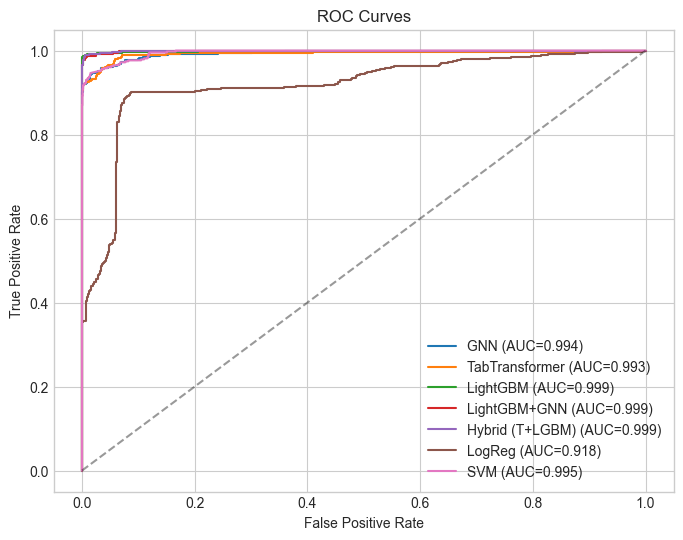

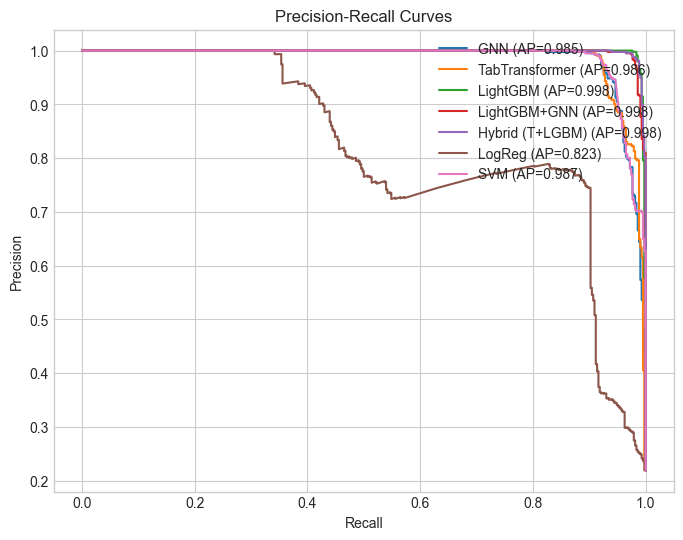

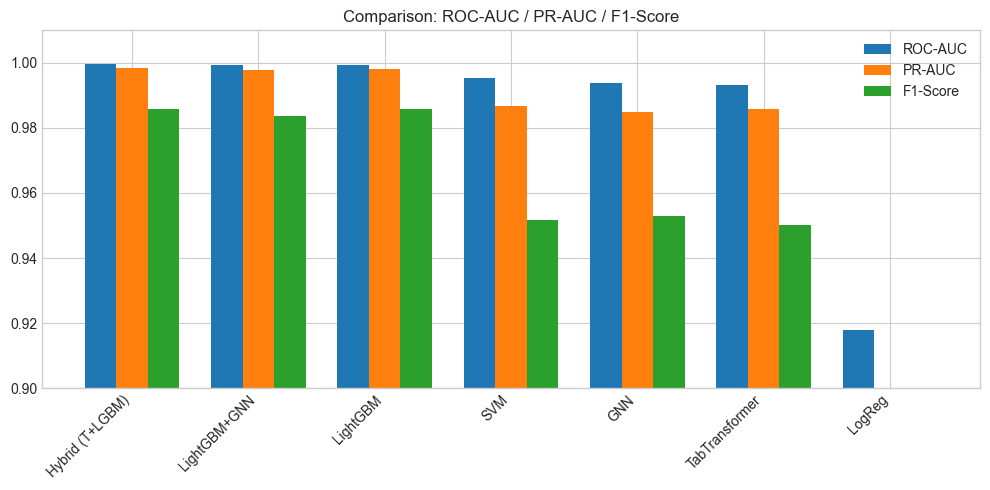

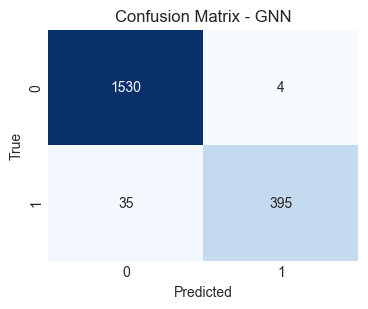

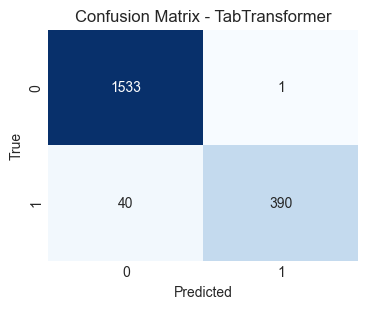

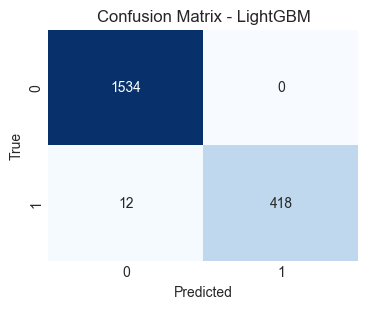

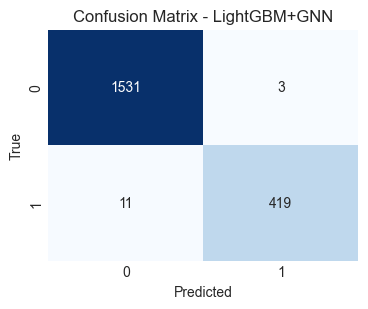

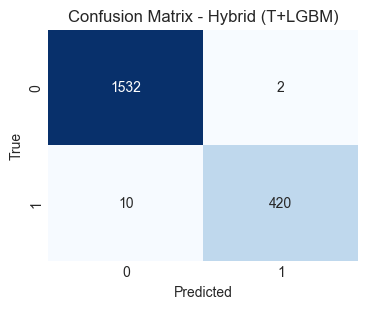

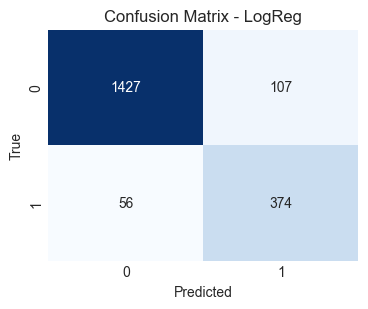

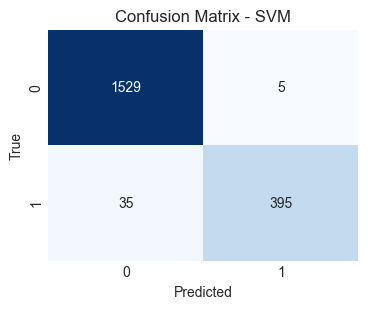

Saved comparison metrics to: ./artifacts\models_comparison_metrics.csv


In [12]:
# Robust final compare cell — now includes all model results automatically
import os, numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

ART = './artifacts'
assert os.path.isdir(ART), f"Artifacts dir not found: {ART}"

# Models to compare (added Hybrid Transformer + LightGBM)
model_names = ['GNN', 'TabTransformer', 'LightGBM', 'LightGBM+GNN', 'Hybrid (T+LGBM)', 'LogReg', 'SVM']

canonical_map = {
    'GNN': 'gnn_test_probs.npy',
    'TabTransformer': 'tab_test_probs.npy',
    'LightGBM': 'lightgbm_test_probs.npy',
    'LightGBM+GNN': 'lightgbm_with_gnn_test_probs.npy',
    'Hybrid (T+LGBM)': 'hybrid_test_probs.npy', # <-- New model
    'LogReg': 'logreg_test_probs.npy',
    'SVM': 'svm_test_probs.npy'
}

pattern_map = {
    'GNN': ['gnn'],
    'TabTransformer': ['tabtransformer','tab_transformer','tab-transformer','tab'],
    'LightGBM': ['lightgbm','lgb'],
    'LightGBM+GNN': ['lightgbm_with_gnn','gnn_lightgbm','gnn_lgb'],
    'Hybrid (T+LGBM)': ['hybrid', 'transformer_lightgbm'], # <-- New pattern
    'LogReg': ['logreg','log_reg','logistic'],
    'SVM': ['svm']
}

all_files = sorted([f for f in os.listdir(ART) if f.lower().endswith('.npy') and 'test' in f.lower()])
print("Candidate files:", all_files)

# Load y_test
y_true = None
y_true_path = os.path.join(ART, "y_test.npy")
if os.path.exists(y_true_path):
    y_true = np.load(y_true_path, allow_pickle=True)
else:
    # Fallback to find any file ending with _true.npy
    for f in all_files:
        if f.lower().endswith('_true.npy'):
            y_true = np.load(os.path.join(ART, f), allow_pickle=True)
            break
assert y_true is not None, "Could not find y_test.npy or *_true.npy"
n_y = len(y_true)
print("Loaded y_test length:", n_y)

# Helper to validate files
def check_candidate(path):
    try:
        arr = np.load(path, allow_pickle=True)
        arr = np.asarray(arr, dtype=float).ravel()
        if arr.ndim == 1 and arr.shape[0] == n_y:
            return arr
    except Exception:
        pass
    return None

used_files = set()
results = {}

for model in model_names:
    chosen_file, chosen_arr = None, None

    # 1) Try canonical name first
    can = canonical_map.get(model)
    if can:
        p = os.path.join(ART, can)
        if os.path.exists(p) and can not in used_files:
            arr = check_candidate(p)
            if arr is not None:
                chosen_file, chosen_arr = can, arr

    # 2) Fallback to pattern matching
    if chosen_file is None:
        patterns = pattern_map.get(model, [model.lower()])
        for pat in patterns:
            candidates = [f for f in all_files if pat in f.lower() and 'test' in f.lower() and 'prob' in f.lower()]
            candidates = sorted(candidates, key=lambda x: len(x)) # Prefer shorter names
            for cand in candidates:
                if cand in used_files:
                    continue
                arr = check_candidate(os.path.join(ART, cand))
                if arr is not None:
                    chosen_file, chosen_arr = cand, arr
                    break
            if chosen_file:
                break

    if chosen_file is None:
        print(f"[WARN] Could not find a suitable probs file for model {model}. Skipping.")
        continue

    used_files.add(chosen_file)

    # Load preds if available, otherwise compute from probs
    preds = None
    preds_candidates = [
        chosen_file.replace('probs', 'preds'),
        chosen_file.replace('prob', 'preds')
    ]
    token = model.lower()
    preds_candidates += [f for f in all_files if token in f.lower() and 'pred' in f.lower()]
    for pc in preds_candidates:
        pc_path = os.path.join(ART, pc)
        if os.path.exists(pc_path):
            try:
                preds_arr = np.load(pc_path, allow_pickle=True)
                if len(preds_arr) == n_y:
                    preds = preds_arr
                    break
            except Exception:
                pass
    if preds is None:
        preds = (chosen_arr > 0.5).astype(int)

    print(f"Using probs file for {model}: {chosen_file}")
    results[model] = {'probs': chosen_arr, 'preds': preds}

print("\nModels discovered and loaded:", list(results.keys()))

# Build metrics DataFrame
rows = []
for name, vals in results.items():
    probs, preds = vals['probs'], vals['preds']
    auc_score = roc_auc_score(y_true, probs)
    pr_auc = average_precision_score(y_true, probs)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, preds, average='binary', zero_division=0)
    acc = (preds == y_true).mean()
    rows.append({'model': name, 'ROC-AUC': auc_score, 'PR-AUC': pr_auc,
                 'precision': prec, 'recall': rec, 'f1': f1, 'acc': acc})

df_metrics = pd.DataFrame(rows).sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
print("\nFinal metrics:\n", df_metrics)

# === PLOTS ===
plt.style.use('seaborn-v0_8-whitegrid')

# ROC Curves
plt.figure(figsize=(8,6))
for name, vals in results.items():
    fpr, tpr, _ = roc_curve(y_true, vals['probs'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves'); plt.legend(loc='lower right'); plt.show()

# Precision-Recall Curves
plt.figure(figsize=(8,6))
for name, vals in results.items():
    pr, rc, _ = precision_recall_curve(y_true, vals['probs'])
    ap = average_precision_score(y_true, vals['probs'])
    plt.plot(rc, pr, label=f"{name} (AP={ap:.3f})")
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curves'); plt.legend(loc='upper right'); plt.show()

# Bar chart comparison
plt.figure(figsize=(10,5))
x = np.arange(len(df_metrics))
width = 0.25
plt.bar(x - width, df_metrics['ROC-AUC'], width, label='ROC-AUC')
plt.bar(x, df_metrics['PR-AUC'], width, label='PR-AUC')
plt.bar(x + width, df_metrics['f1'], width, label='F1-Score')
plt.xticks(x, df_metrics['model'], rotation=45, ha="right"); plt.ylim(0.9, 1.01)
plt.title('Comparison: ROC-AUC / PR-AUC / F1-Score'); plt.legend(); plt.tight_layout(); plt.show()

# Confusion Matrices
for name, vals in results.items():
    cm = confusion_matrix(y_true, vals['preds'])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

out_path = os.path.join(ART, "models_comparison_metrics.csv")
df_metrics.to_csv(out_path, index=False)
print("Saved comparison metrics to:", out_path)

In [21]:
leaks = [c for c in ['Unnamed: 0', 'Index'] if c in feature_cols]
print("Leaky columns present in feature_cols:", leaks)

# also check original df if available
if os.path.exists('/mnt/data/ethereum_raw.csv'):
    df = pd.read_csv('/mnt/data/ethereum_raw.csv', low_memory=False)
    print("Original df columns containing 'Unnamed' or 'Index':", [c for c in df.columns if 'Unnamed' in c or 'Index' in c])


Leaky columns present in feature_cols: []


In [22]:
import numpy as np, os
ART = "./artifacts"
X_train = np.load(os.path.join(ART, "X_train.npy")); X_val = np.load(os.path.join(ART, "X_val.npy")); X_test = np.load(os.path.join(ART, "X_test.npy"))
y_train = np.load(os.path.join(ART, "y_train.npy")); y_val = np.load(os.path.join(ART, "y_val.npy")); y_test = np.load(os.path.join(ART, "y_test.npy"))

# stacked order check
n_train, n_val, n_test = X_train.shape[0], X_val.shape[0], X_test.shape[0]
print("Split sizes (train,val,test):", n_train, n_val, n_test)

# If graph artifacts exist, check their node count and that addresses match
if os.path.exists(os.path.join(ART, "graph_artifacts.pt")):
    import torch
    art = torch.load(os.path.join(ART, "graph_artifacts.pt"))
    x_nodes = art['x'].cpu().numpy()
    addresses_graph = art.get('addresses', None)
    print("Graph nodes:", x_nodes.shape[0], "expected nodes (stacked):", n_train + n_val + n_test)
    if addresses_graph is not None:
        # address overlap check with saved address splits
        a_tr = np.load(os.path.join(ART, "addresses_train.npy"), allow_pickle=True)
        a_va = np.load(os.path.join(ART, "addresses_val.npy"), allow_pickle=True)
        a_te = np.load(os.path.join(ART, "addresses_test.npy"), allow_pickle=True)
        set_overlap = len(set(a_tr) & set(a_te))
        print("Train/Test address overlap (should be 0):", set_overlap)


Split sizes (train,val,test): 6674 1178 1964
Graph nodes: 9816 expected nodes (stacked): 9816
Train/Test address overlap (should be 0): 0


C:\Users\manis\AppData\Local\Temp\ipykernel_7400\1791476039.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(os.path.join(ART, "graph_artifacts.pt"))


In [23]:
# OPTION A — quick check if you already ran the helper cell
print("w3 exists:", 'w3' in globals())
if 'w3' in globals():
    print("Connected:", w3.is_connected())
if 'contract' in globals():
    print("Contract address:", contract.address)
    try:
        print("Contract owner:", contract.functions.owner().call())
    except Exception as e:
        print("owner() call failed:", e)
    try:
        print("Transaction count:", contract.functions.getTransactionCount().call())
    except Exception as e:
        print("getTransactionCount() failed:", e)


w3 exists: False


In [1]:
import pickle
import numpy as np
import lightgbm as lgb
import pandas as pd
from web3 import Web3
import os
import hashlib
import json

def get_file_hash(filepath):
    """Calculates the SHA-256 hash of a file."""
    sha256_hash = hashlib.sha256()
    with open(filepath, "rb") as f:
        # Read the file in chunks to handle large files efficiently
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.digest() # .digest() returns the hash as bytes

def get_dict_hash(data_dict):
    """Calculates the SHA-256 hash of a dictionary."""
    # Convert the dictionary to a sorted JSON string to ensure consistency
    encoded_string = json.dumps(data_dict, sort_keys=True).encode()
    return hashlib.sha256(encoded_string).digest()
# Define the path to your saved artifacts
# NOTE: This script assumes you have an 'artifacts' directory 
# with 'lightgbm_booster_final.txt' and 'preproc_train_encoders.pkl'
# in the same directory where you run this file.
ARTIFACTS_DIR = os.path.join(os.getcwd(), 'artifacts') 

# --- Global Artifacts Storage ---
bst = None
scaler = None
cat_encoders = None
numeric_cols = None
categorical_cols = None

# --- Load the trained model and preprocessing objects ---
def load_artifacts():
    global bst, scaler, cat_encoders, numeric_cols, categorical_cols
    try:
        # Load the LightGBM model booster
        # If the model is a text file, use model_file. If it's a binary dump, use pickle.load.
        # Assuming model_file is correct based on your original code.
        bst = lgb.Booster(model_file=f'{ARTIFACTS_DIR}/lightgbm_booster_final.txt')
        print(f"✅ LightGBM model loaded from: {ARTIFACTS_DIR}/lightgbm_booster_final.txt")
        
        # Load the preprocessing dictionary (contains scaler, encoders, column lists)
        with open(f'{ARTIFACTS_DIR}/preproc_train_encoders.pkl', 'rb') as f:
            preproc_artifacts = pickle.load(f)
            
        scaler = preproc_artifacts['scaler']
        cat_encoders = preproc_artifacts['cat_encoders']
        numeric_cols = preproc_artifacts['numeric_cols']
        categorical_cols = preproc_artifacts['categorical_cols']
        print(f"✅ Preprocessing artifacts loaded from: {ARTIFACTS_DIR}/preproc_train_encoders.pkl")

    except FileNotFoundError as e:
        print(f"❌ Error loading artifacts: {e}")
        print("Please make sure the 'artifacts' directory exists and contains the model and encoder files.")
        exit()
    except Exception as e:
        print(f"❌ An unexpected error occurred during artifact loading: {e}")
        exit()

# Load the necessary files immediately
load_artifacts()


def predict_single_transaction(transaction_data):
    """
    Takes a single transaction as a dictionary, preprocesses it,
    and returns a fraud prediction (True/False).
    
    This function relies on globally loaded artifacts (bst, scaler, etc.).
    """
    if bst is None:
        print("Model artifacts not loaded. Exiting prediction.")
        return False

    # Convert dictionary to a pandas DataFrame/Series for easier handling
    df_single = pd.DataFrame([transaction_data])

    # Ensure all required columns are present (fill missing ones with NaN for safety)
    all_cols = numeric_cols + categorical_cols
    for col in all_cols:
        if col not in df_single.columns:
            df_single[col] = np.nan


    # 1. Separate numeric and categorical features
    # Use the globally defined column lists
    X_raw_num = df_single[numeric_cols].copy()
    X_raw_cat = df_single[categorical_cols].copy()

    # 2. Preprocess Categorical Features (must match training exactly)
    X_cat = np.empty((1, len(categorical_cols)), dtype=np.int32)
    for i, col in enumerate(categorical_cols):
        # Fill missing values with the same sentinel token used in training
        val = str(X_raw_cat[col].fillna("<<NA>>").iloc[0])
        
        # Get the mapping and unknown index from the loaded encoder
        encoder_info = cat_encoders[col]
        mapping = encoder_info['mapping']
        unk_index = encoder_info['unk_index']
        
        # Apply the mapping, using unk_index for unseen categories
        X_cat[0, i] = mapping.get(val, unk_index)

    # 3. Preprocess Numeric Features (must match training exactly)
    # Fill missing values with 0, as done in training
    X_num_scaled = scaler.transform(X_raw_num.fillna(0).values)

    # 4. Combine preprocessed features into a single feature vector
    # LightGBM expects the input features to be float type
    X_final = np.hstack([X_num_scaled, X_cat.astype(float)])

    # 5. Make the prediction
    # Predict returns an array, we take the first (and only) element
    probability = bst.predict(X_final)[0] 
    
    # Convert to True (fraud) or False (not fraud) based on a 0.5 threshold
    prediction = bool(probability > 0.5) 

    print(f"📊 Model Prediction -> Probability: {probability:.4f}, Is Fraud: {prediction}")
    
    return prediction


# --- 1. Blockchain Connection (Same as before) ---
ganache_url = "http://127.0.0.1:7545"
web3 = Web3(Web3.HTTPProvider(ganache_url))

if web3.is_connected():
    print("\n✅ Connected to Ganache!")
else:
    print("\n❌ Connection failed. Please ensure Ganache is running on 7545.")
    exit()

# The contract address and ABI are required to interact with the deployed contract
contract_address = "0x95394aC5f3f5A802d60E678549e7C6FAfB217be2"
contract_abi = [
    {
        "inputs": [],
        "stateMutability": "nonpayable",
        "type": "constructor"
    },
    {
        "anonymous": False,
        "inputs": [
            {
                "indexed": True,
                "internalType": "uint256",
                "name": "id",
                "type": "uint256"
            },
            {
                "indexed": False,
                "internalType": "address",
                "name": "user",
                "type": "address"
            },
            {
                "indexed": False,
                "internalType": "uint256",
                "name": "amount",
                "type": "uint256"
            },
            {
                "indexed": False,
                "internalType": "bool",
                "name": "isFraudulent",
                "type": "bool"
            },
            {
                "indexed": False,
                "internalType": "bytes32",
                "name": "modelHash",
                "type": "bytes32"
            },
            {
                "indexed": False,
                "internalType": "bytes32",
                "name": "inputHash",
                "type": "bytes32"
            }
        ],
        "name": "TransactionRecorded",
        "type": "event"
    },
    {
        "inputs": [
            {
                "internalType": "address",
                "name": "_user",
                "type": "address"
            },
            {
                "internalType": "uint256",
                "name": "_amount",
                "type": "uint256"
            },
            {
                "internalType": "bool",
                "name": "_isFraudulent",
                "type": "bool"
            },
            {
                "internalType": "bytes32",
                "name": "_modelHash",    # <-- The new hash parameters are here
                "type": "bytes32"
            },
            {
                "internalType": "bytes32",
                "name": "_inputHash",    # <-- The new hash parameters are here
                "type": "bytes32"
            }
        ],
        "name": "recordTransaction",
        "outputs": [],
        "stateMutability": "nonpayable",
        "type": "function"
    },
    {
        "inputs": [],
        "name": "getTransactionCount",
        "outputs": [
            {
                "internalType": "uint256",
                "name": "",
                "type": "uint256"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [],
        "name": "owner",
        "outputs": [
            {
                "internalType": "address",
                "name": "",
                "type": "address"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [
            {
                "internalType": "uint256",
                "name": "",
                "type": "uint256"
            }
        ],
        "name": "transactions",
        "outputs": [
            {
                "internalType": "address",
                "name": "user",
                "type": "address"
            },
            {
                "internalType": "uint256",
                "name": "amount",
                "type": "uint256"
            },
            {
                "internalType": "bool",
                "name": "isFraudulent",
                "type": "bool"
            },
            {
                "internalType": "uint256",
                "name": "timestamp",
                "type": "uint256"
            },
            {
                "internalType": "bytes32",
                "name": "modelHash",
                "type": "bytes32"
            },
            {
                "internalType": "bytes32",
                "name": "inputHash",
                "type": "bytes32"
            }
        ],
        "stateMutability": "view",
        "type": "function"
    }
]

# Instantiate the contract object
contract = web3.eth.contract(address=contract_address, abi=contract_abi)
# Get all accounts from Ganache
accounts = web3.eth.accounts
# Use the first account for sending transactions
sender_account = accounts[0]
print(f"Using sender account: {sender_account}")


# --- 2. Simulate a New Transaction to Predict On ---
# This dictionary represents a new transaction. 
# The keys MUST match the column names from your original training data
new_transaction_data = {
    'Avg min between sent tnx': 844.26, 'Avg min between received tnx': 1093.71,
    'Time Diff between first and last (Mins)': 704785.63, 'Sent tnx': 721,
    'Received Tnx': 89, 'Number of Created Contracts': 0,
    'Unique Received From Addresses': 40, 'Unique Sent To Addresses': 118,
    'min value received': 0.0, 'max value received ': 12.0, 'avg val received': 0.5358,
    'min val sent': 0.0, 'max val sent': 6.5, 'avg val sent': 0.0216,
    'min value sent to contract': 0, 'max val sent to contract': 0,
    'avg value sent to contract': 0,
    'total transactions (including tnx to create contract': 810,
    'total Ether sent': 15.58, 'total ether received': 47.69,
    'total ether sent contracts': 0.0, 'total ether balance': 32.11,
    ' Total ERC20 tnxs': 615, ' ERC20 total Ether received': 1.6833e+07,
    ' ERC20 total ether sent': 1.6831e+07, ' ERC20 total Ether sent contract': 0.0,
    ' ERC20 uniq sent addr': 106, ' ERC20 uniq rec addr': 36,
    ' ERC20 uniq sent addr.1': 0, ' ERC20 uniq rec contract addr': 1,
    ' ERC20 avg time between sent tnx': 1276.08, ' ERC20 avg time between rec tnx': 235.81,
    ' ERC20 avg time between rec 2 tnx': 0, ' ERC20 avg time between contract tnx': 0,
    ' ERC20 min val rec': 0.0, ' ERC20 max val rec': 1.6831e+07,
    ' ERC20 avg val rec': 27367.39, ' ERC20 min val sent': 0.0,
    ' ERC20 max val sent': 1.6831e+07, ' ERC20 avg val sent': 271779.92,
    ' ERC20 min val sent contract': 0.0, ' ERC20 max val sent contract': 0.0,
    ' ERC20 avg val sent contract': 0.0, ' ERC20 uniq sent token name': 39.0,
    ' ERC20 uniq rec token name': 57.0, ' ERC20 most sent token type': 'Cofoundit',
    ' ERC20_most_rec_token_type': 'Numeraire'
}


# --- 3. Get Prediction from the Model ---
print("\n🧠 Getting fraud prediction from the ML model...")
is_fraud_prediction = predict_single_transaction(new_transaction_data)


# --- 4. Record the Prediction and Fingerprints on the Blockchain (Final Version) ---
print("\n📝 Recording the predicted transaction and its digital fingerprints on the blockchain...")

# --- FIX 1: Add the user address to your simulated data ---
new_transaction_data['Address'] = '0x05e3650bfc907cc1b3c774f0c053c8b990ce1a4b'
user_to_record = new_transaction_data['Address'] 

# --- FIX 2: Get the transaction amount from the data ---
amount_in_eth = new_transaction_data['total Ether sent']
amount_in_wei = web3.to_wei(amount_in_eth, 'ether')

# --- FIX 3 (NEW): Generate the Digital Fingerprints ---
# Get the hash of the model file
model_filepath = f'{ARTIFACTS_DIR}/lightgbm_booster_final.txt'
model_hash = get_file_hash(model_filepath)

# Get the hash of the input data that the model is predicting on
input_hash = get_dict_hash(new_transaction_data)

print(f"Model Fingerprint (Hash): {model_hash.hex()}")
print(f"Input Data Fingerprint (Hash): {input_hash.hex()}")

# --- FIX 4 (NEW): Call the UPDATED contract function with the hashes ---
# The function now takes 5 arguments instead of 3
tx_hash = contract.functions.recordTransaction(
    web3.to_checksum_address(user_to_record),  # User address
    amount_in_wei,                            # Amount
    is_fraud_prediction,                      # The model's prediction
    model_hash,                               # The model's fingerprint
    input_hash                                # The input data's fingerprint
).transact({
    'from': sender_account                    # The account paying the gas fee
})

# Wait for the transaction to be mined (same as before)
try:
    receipt = web3.eth.wait_for_transaction_receipt(tx_hash)
    print(f"✅ Transaction successful! Block: {receipt.blockNumber}, Hash: {receipt.transactionHash.hex()}")
    
    # Check the total count of transactions stored on the contract
    count = contract.functions.getTransactionCount().call()
    print(f"📊 Total transactions now stored on-chain: {count}")
    
except Exception as e:
    print(f"❌ Transaction failed or timed out: {e}")

✅ LightGBM model loaded from: e:\Projects\CBK_Assignment\Greenland_Registry\GNN_TabTransformer_AddressLevel\artifacts/lightgbm_booster_final.txt
✅ Preprocessing artifacts loaded from: e:\Projects\CBK_Assignment\Greenland_Registry\GNN_TabTransformer_AddressLevel\artifacts/preproc_train_encoders.pkl

✅ Connected to Ganache!
Using sender account: 0x8dB6F6a9c9eD6c4225Cb424b5ea471C5E0Cf86fC

🧠 Getting fraud prediction from the ML model...
📊 Model Prediction -> Probability: 0.9872, Is Fraud: True

📝 Recording the predicted transaction and its digital fingerprints on the blockchain...
Model Fingerprint (Hash): 196462fbe5bb9707ed6d48c0512598d31f688f284445c44c93638b03325244b9
Input Data Fingerprint (Hash): 96d4dd8da312b4db6801f1584865102d8ade9501c61b07b332bd226f8aaaec54
✅ Transaction successful! Block: 357, Hash: 2ab3447727caf1f494ccbadbed2ba09771340b2dc62b906646435f29f30a3e76
📊 Total transactions now stored on-chain: 1
